In [1]:
## Bring in needed mods
import numpy as np, pandas as pd, glob, os, scipy.stats as ss
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
## Bring in more mods
from matplotlib.gridspec import GridSpec
plt.style.use(['tableau-colorblind10'])

In [3]:
## Bring in seaborn
import seaborn as sns
sns.set(font_scale=1)
sns.set(style="ticks", context="talk")

In [4]:
## Set labels
from matplotlib import rc
amphB_text = 'Amphotericin B'
xl280al = 'XL280'+r'$\alpha$'#+'SS'
xl280a = 'XL280' +r'$\bf{a}$'
_431 = '431'+r'$\mathrm{\alpha}$'
labels = [xl280a,_431]

In [5]:
## Define ftns for temproal QTL mapping
def allelic_time(site, pheno,coeff = False):
    coding = np.array(site, np.float)
    pheno = np.array(pheno.loc[site.index], np.float)
    assert len(pheno) == len(coding)
    meany = pheno.mean(axis=0)
    meandummy = coding.mean(axis=0)
    ctry = pheno - meany
    ctrdummy = coding - meandummy
    # regression coefficient and intercept
    b = np.dot(ctry.T, ctrdummy)/np.dot(ctrdummy, ctrdummy)
    intercept = meany - b * meandummy
    
    yhat = np.outer(ctrdummy,b)
    
    len_yhat = np.sqrt(np.dot(yhat.T,yhat))
    len_y = np.sqrt(np.dot(ctry.T,ctry))
    df_yhat = 1
    
    error = ctry - yhat
    len_error = np.sqrt(np.dot(error.T,error))
    df_error = len(pheno) - 2
    
    F = np.diag((len_yhat**2/df_yhat) / (len_error**2/df_error))
    return F

def association_time(site, pheno):
    F = allelic_time(site, pheno)
    return -np.log10(ss.f.sf(F, 1, len(pheno)-2))

def allelic_ANOVA(site, pheno):
    """This regression is equivalent to one-way ANOVA with 2 groups. Return F-statistic.

    Assumes site is coded as -1, 1
    """
    pheno = pheno.dropna();assert len(pheno) > 0;
    coding = np.array(site[pheno.dropna().index.tolist()],np.float)
    pheno = np.array(pheno,np.float)

    meany = np.mean(pheno)
    meandummy = np.mean(coding)
    ctry = pheno - meany
    ctrdummy = coding - meandummy
    
    # regression coefficient and intercept
    b = np.dot(ctry, ctrdummy)/np.dot(ctrdummy, ctrdummy)
    intercept = meany - b * meandummy
    
    yhat = b * ctrdummy
    len_yhat = np.sqrt(np.dot(yhat,yhat))
    len_y = np.sqrt(np.dot(ctry,ctry))
    df_yhat = 1
    
    error = ctry  - yhat
    len_error = np.sqrt(np.dot(error,error))
    if abs(len_error**2) < 1e-5:
        raise Exception("Zero length error in ANOVA")
    df_error = len(pheno) - 2
    
    # coefficient of determination is R**2
    #R = len_yhat/len_y
    
    # F-statistic
    F = (len_yhat**2/df_yhat) / (len_error**2/df_error)
    return F

def association_logPval(site, pheno):
    F = allelic_ANOVA(site, pheno)
    logP = np.log10(ss.f.sf(F, 1, len(pheno)-2))
    return -logP

def find_median(df,time,S='strain'):
    samples = df[S].unique()
    six = []
    for s in samples:
        sdf = df[(df[S]==s)]
        k = np.abs(sdf[time].T.sum() - sdf[time].T.sum().median()).idxmin() ## AUC
        #k = np.abs(sdf[time].T.max() - sdf[time].T.max().median()).idxmin() ## Max OD
        six.append((s,k))
    return pd.DataFrame(six,columns=[S,'Medianix'])

def myminmax(x):
    x = np.array(x)
    return (x-x.min())/(x.max()-x.min())

In [6]:
## Set needed variables
## These may need to be edited based on your paths
date = 'Jan162019'
parentals = ['SS-A837','XL280a','XL280alpha']

## set paths to phenotype and genotype data
data_path = '../DATA/PHENOTYPE/GROWTHCURVES/Tecan_qtlruns_%s_curated_baselined_median51.csv.gz'%date
geno_path = '../DATA/GENOTYPE/CDx-ill-SNP-INDEL-df-104-blocked.csv.gz'

## Set savepath for QTL data
filesave = data_path.split('.csv')[0]+'_QTL_x_time.csv.gz'

## Set gff path and gene analysis path
gff_path = '../DATA/xl280genome.gff3.csv.gz'

## Set gene anlaysis path
gene_analysis_path  = '../DATA/XL280_431_gene_analysis.csv.gz'

## centromere path
cent_path = '../DATA/XL280-centromere-locs.csv'

## P-value significance thresholds path
thresholds_path = '../DATA/PERMUTATIONS/Cdx-aucxt-thresholds-Sep2019.csv'

## Set colors
pcolors = ['tab:orange','tab:brown','tab:red']
chrom_colors = ['tab:grey','tab:brown','lightgrey','salmon','tan']

## Set other plotting labels
sigs_ls = ('dotted','dashed')
sig_labs = ('\u03B1 = 0.01','\u03B1 = 0.05')

In [7]:
## Bring in genomic feature file, analysis of XL280 and 431 genes
## and centromere locations
gff = pd.read_csv(gff_path,index_col=0)
genes = pd.read_csv(gene_analysis_path)
centlocs = pd.read_csv(cent_path,index_col=0)

In [8]:
## Gather variables from phenotype data
df = pd.read_csv(data_path,index_col=0)
dfcol = df.columns.tolist()
time_ix = dfcol.index('6300s')
times_ixs = dfcol[time_ix:]
#df.index = df.strain
timex = [np.round(int(a[:-1])/(60**2),3) for a in times_ixs]
dx = np.max(np.diff(timex))

In [9]:
## Gather geneotype variables like strains used. There should be 104 strains
geno_df = pd.read_csv(geno_path)
strain_ix = geno_df.columns.tolist().index('Block') + 1
geno_strains = np.array(geno_df.columns.tolist()[strain_ix:])
len(geno_strains)

## Gather unique blocks to test
loci_ix = geno_df['Block'].drop_duplicates().index
len(loci_ix)

3108

In [10]:
## Take haploblocks and just segregant genotypes
geno_x = geno_df[geno_strains].T[loci_ix].T

In [11]:
## Take all genotype data for just haploblocks
genoxdf = pd.concat([geno_df[geno_df.columns[:strain_ix]].T[loci_ix].T,
                     geno_x],axis=1)
genoxdf.head()

Chrom    Pos     Qual Callrate Ref Alt Altlen     Dp Type Vcfix  ...  \
0    Chr01   5016   104492        1   C   A      1   6510  snp   289  ...   
232  Chr01  35512   133717        1   G   A      1  10640  snp  1398  ...   
249  Chr01  36364  93835.8        1   A   G      1   7564  snp  1429  ...   
252  Chr01  36573  91163.2        1   C   T      1   7662  snp  1438  ...   
254  Chr01  36769  94014.2        1   C   T      1   7565  snp  1447  ...   

    SS-B598 SS-B565 SS-B600 SS-B574 SS-B872_cor SS-B873_cor SS-B360 SS-B397  \
0       1.0     0.0     1.0     1.0         0.0         0.0     1.0     0.0   
232     1.0     0.0     1.0     1.0         0.0         0.0     1.0     0.0   
249     1.0     0.0     1.0     1.0         0.0         0.0     1.0     0.0   
252     1.0     0.0     1.0     1.0         0.0         0.0     1.0     0.0   
254     1.0     1.0     1.0     1.0         0.0         0.0     1.0     0.0   

    SS-B564 SS-B382  
0       1.0     0.0  
232     1.0     0.0  
249     1.0     0.0  
252     1.0     0.0  
254     1.0     0.0  

[5 rows x 125 columns]

In [12]:
## Gather the segregants and phenotypes for QTL mapping
segs = [s for s in geno_strains if s not in parentals]

df = df[(df.strain.isin(segs+parentals))]
df.strain.unique().shape

(104,)

In [13]:
## Gather the unique conditons
condi = df[['temp','amphB']].drop_duplicates().sort_values(
                    by=['temp','amphB']).reset_index(drop=True)
condi.head()

temp  amphB
0    30  0.000
1    30  0.075
2    30  0.125
3    30  0.175
4    37  0.000

In [14]:
## Take unique vectors of temps and drugs
temps = condi.temp.unique()
drugs = condi.amphB.unique()

In [15]:
## Set all columns to float type
for s in times_ixs:
    df[s] = df[s].apply(float)

In [16]:
## Check reproducabilty at 30C with zero drug
reptest = df[(df.temp==30) & (df.amphB==0)
            ].sort_values('strain').copy()
#reptest.index = reptest.strain

## Calculate final AUC
reptest['AUC'] = reptest[times_ixs].sum(axis=1)*dx
reptest.T.tail().T.head()

254700s 255601s 256500s 257400s      AUC
0  1.4098  1.4098  1.4098  1.4098   74.951
1  1.4172  1.4172  1.4182  1.4182  70.8508
2  1.4178  1.4188  1.4188  1.4188   70.487
3  1.4272  1.4272  1.4272  1.4272  74.8425
4   0.961   0.962   0.962   0.962   43.068

In [17]:
## Gather unique dates of plates
p1_dates = reptest[(reptest.plate==1)].date.unique()
p2_dates = reptest[(reptest.plate==2)].date.unique()
len(p1_dates),len(p2_dates)

(3, 4)

In [18]:
## Gather replicates
rep1 = [a[1].AUC.values[0] for a in 
        reptest.sort_values(['strain','date','AUC']
                           ).groupby('strain')]

rep2 = [a[1].AUC.values[1] for a in 
        reptest.sort_values(['strain','date','AUC']
                           ).groupby('strain')]

rep3 = [a[1].AUC.values[2] for a in 
        reptest.sort_values(['strain','date','AUC']
                           ).groupby('strain')]

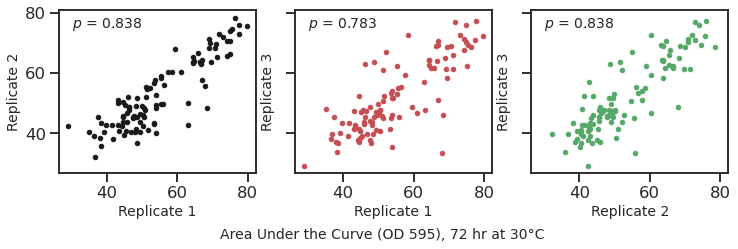

In [19]:
## Compare replicates
fig,ax = plt.subplots(1,3,figsize=(12,3),sharex=True,sharey=True)

plt.sca(ax[0])
plt.plot(rep1,rep2,'k.');
sp = np.round(ss.spearmanr(rep1,rep2)[0],3)
plt.text(30,75,'$p$ = %s'%sp,fontsize=14)
plt.xlabel('Replicate 1',fontsize=14)
plt.ylabel('Replicate 2',fontsize=14)


plt.sca(ax[1])
plt.plot(rep1,rep3,'r.');
sp = np.round(ss.spearmanr(rep1,rep3)[0],3)
plt.text(30,75,'$p$ = %s'%sp,fontsize=14)
plt.xlabel('Replicate 1',fontsize=14)
plt.ylabel('Replicate 3\n',fontsize=14)



plt.sca(ax[2])
plt.plot(rep2,rep3,'g.');
sp = np.round(ss.spearmanr(rep2,rep3)[0],3)
plt.text(30,75,'$p$ = %s'%sp,fontsize=14);
plt.xlabel('Replicate 2',fontsize=14)
plt.ylabel('Replicate 3\n',fontsize=14)


fig.text(0.5,-0.16,'Area Under the Curve (OD 595), 72 hr at 30\u00B0C',
         fontsize=14,va='center',ha='center');
plt.savefig('/home/croth/Desktop/QTL_REPLICATES/AUC_30_replicates_rank_coeff.png',
           dpi=100,bbox_inches='tight');

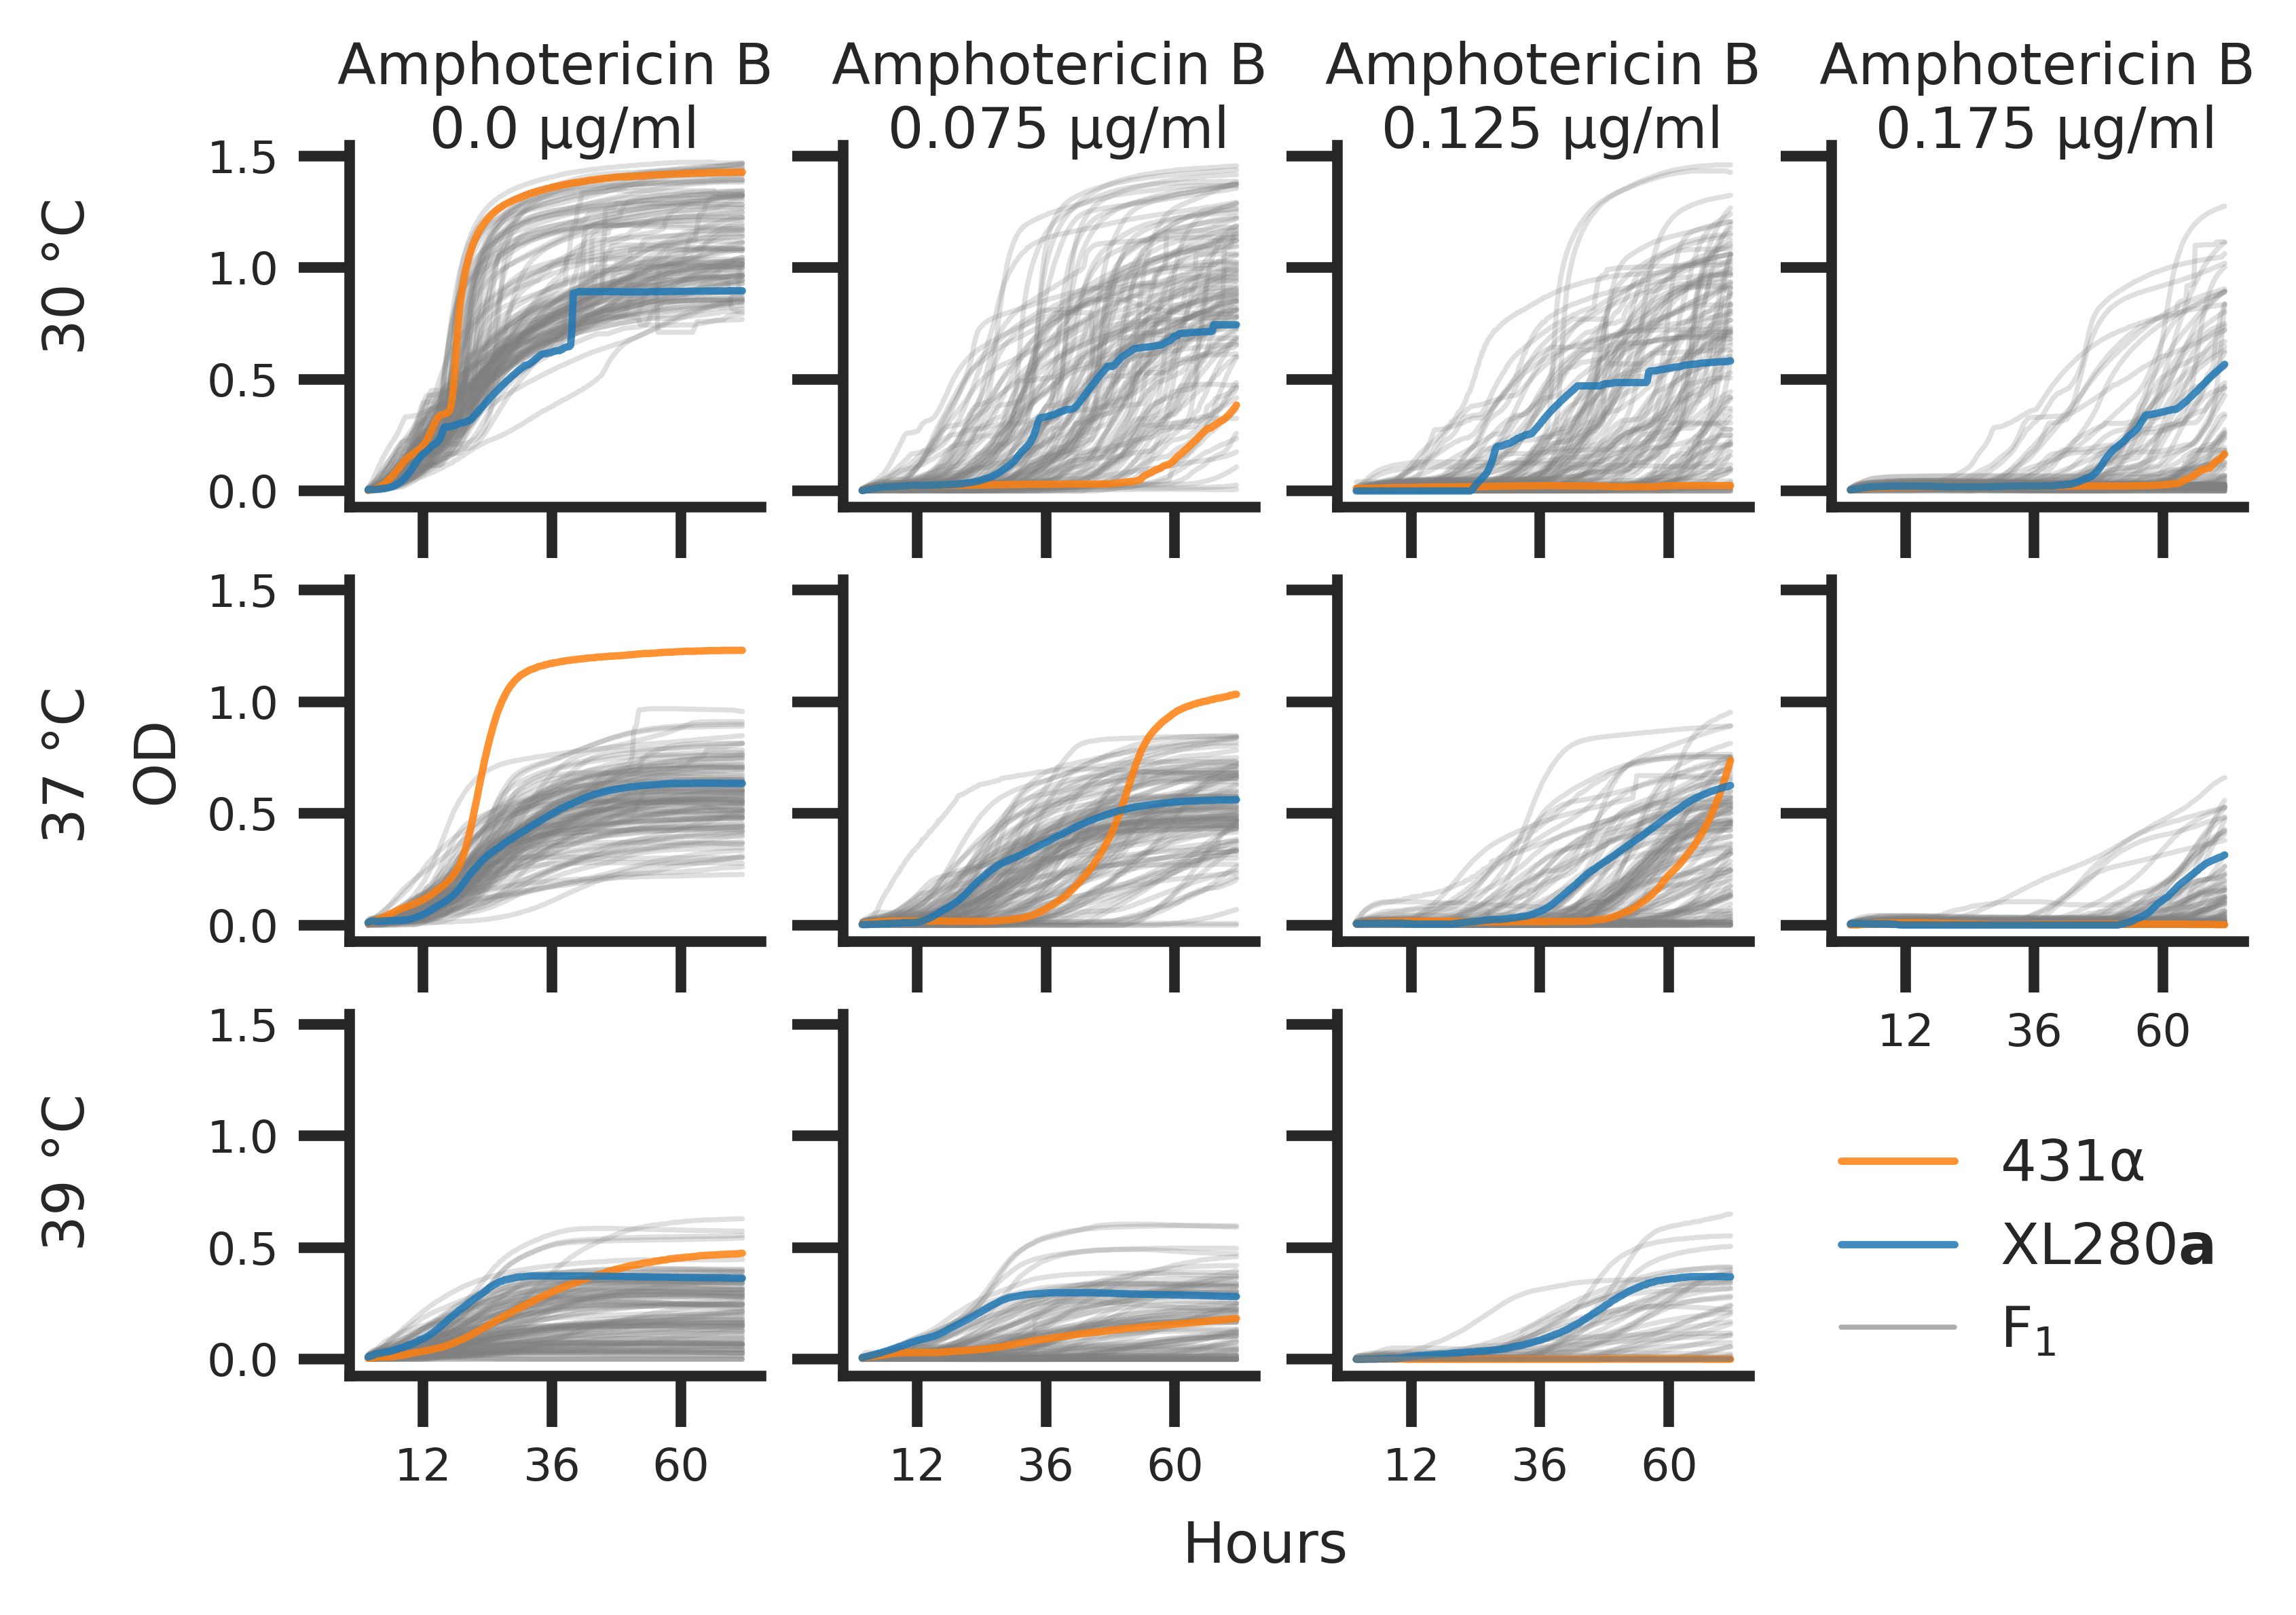

In [20]:
## Make figure 3
mydpi=600
fs = 12
fig, ax = plt.subplots(len(temps),len(drugs),sharey=True,figsize=(6,4),dpi=mydpi)

for i,j in condi.iterrows():
    
    plt.sca(ax.ravel()[i])
    t = j.temp
    d = j.amphB
    
    plt.title('%s\n %s \u03BCg/ml'%(amphB_text,d) if i < 4 else None,y=0.9,fontsize=10)
    
    tempdf = df[(df.temp==t) & (df.amphB==d)]
    
    median_ix_df = find_median(tempdf,times_ixs)
    
    seg_ix = median_ix_df[(median_ix_df.strain.isin(segs))].Medianix
    _431_ix = median_ix_df[(median_ix_df.strain=='SS-A837')].Medianix
    xl280a_ix = median_ix_df[(median_ix_df.strain=='XL280a')].Medianix
    
    plt.plot(timex ,tempdf.T[seg_ix].T[times_ixs].T.values, 
             alpha=0.25,color='grey',linewidth=.9);
    plt.plot(timex ,tempdf.T[_431_ix].T[times_ixs].T.values, 
             alpha=0.85,color='tab:orange',linewidth=1.3,label=_431 if i == 10 else None);
    plt.plot(timex ,tempdf.T[xl280a_ix].T[times_ixs].T.values, 
             alpha=0.85,color='tab:blue',linewidth=1.3,label=xl280a if i == 10 else None);
    
    if i == 10:
        minseg = tempdf[times_ixs[-1]].idxmin()
        plt.plot(timex, tempdf.T[minseg].T[times_ixs],
                 alpha=0.65,color='grey',linewidth=.9,label='F$_1$')
   
        plt.legend(bbox_to_anchor=(1.1,.8),fontsize=10,frameon=False)


    plt.ylabel('OD' if i == 4 else None,fontsize=10)
    plt.yticks(np.arange(0,2,.5),fontsize=8)#,fontweight='bold')
    
    if i > 6:
        plt.xticks(np.arange(12,72,1)[::24],
                       label=np.arange(12,72,1)[::12],
                       fontsize=8)#,fontweight='bold')
    else:
        plt.xticks(np.arange(12,72,1)[::24],labels=[])
        
    [ax.ravel()[i].spines[a].set_visible(False) for a in ['top','right']]
yk = [.80,.50,.25]
for i,t in condi.temp.drop_duplicates().reset_index().iterrows():
    fig.text(s = u'%s °C'%t.temp,x=0.01,y=yk[i],
             fontsize=10,ha='center',va='center',rotation=90)
fig.text(s='Hours',x=0.5,y=0.02,fontsize=10,va='center',ha='center')
plt.sca(ax[-1,-1]);plt.axis('off');

fig.savefig('../FIGURES/MAIN/PDFs/Fig3.pdf',
            dpi=mydpi,bbox_inches='tight')

plos_save = '../FIGURES/MAIN/TIFF/Fig3.tiff'
fig.savefig(plos_save,
            dpi=mydpi,bbox_inches='tight');

im = Image.open(plos_save)
w,h = im.size
assert w/mydpi > 2.63
assert w/mydpi < 7.5
assert h/mydpi < 8.5
im.save(plos_save,compression='tiff_lzw')

In [21]:
## Calculate precent of segregants that 
## grew better than the XL280a parent
for i, td in condi.iterrows():
    t = td.temp
    d = td.amphB
    tempdf = df[(df.temp==t) & (df.amphB==d)]
    tempdf.index= tempdf.strain
    cum_med_od = (tempdf[times_ixs].groupby(tempdf.index)[times_ixs
                ].cumsum(axis=1)*dx).groupby(tempdf.index).agg(np.median)
    AUCgx = (cum_med_od.T[segs].T[times_ixs[-1]] > cum_med_od.T['XL280a'].T[times_ixs[-1]]).sum()
    print(t,d,np.round(AUCgx/len(segs),2))

30.0 0.0 0.89
30.0 0.075 0.33
30.0 0.125 0.24
30.0 0.175 0.19
37.0 0.0 0.35
37.0 0.075 0.44
37.0 0.125 0.24
37.0 0.175 0.18
39.0 0.0 0.06
39.0 0.075 0.07
39.0 0.125 0.07


In [22]:
## If the analysis has not been done conduct anlaysis
if not os.path.exists(filesave):
    kwak_time = []
    for i, td in enumerate(txd):
        t = td[0]
        d = td[1]
        tempdf = df[(df.temp==t) & (df.amphB==d)]
        tempdf.index= tempdf.strain
        cum_med_od = (tempdf[times_ixs].groupby(tempdf.index)[times_ixs
                ].cumsum(axis=1)*dx).groupby(tempdf.index).agg(np.median)
        kwak = genoxdf[geno_strains].apply(association_time,axis=1,
                args=[cum_med_od.T[geno_strains].T[times_ixs]]);
        kwak_time.append(kwak)

In [23]:
## On analysis that has been done unfold and group
if not os.path.exists(filesave):
    un_folddfs = []
    for i,td in enumerate(txd):
        kwak = kwak_time[i]
        tempdf = pd.DataFrame.from_dict(dict(zip(kwak.index,kwak.values))).T
        tempdf.columns = times_ixs
        tempdf['Max'] = tempdf.max(axis=1)
        tempdf['Mean'] = tempdf.mean(axis=1)
        tempdf['Temp'] = td[0]
        tempdf['AmphB'] = td[1]
        tempdf[['Chrom','Pos','Block']] = geno_df.T[tempdf.index].T[['Chrom','Pos','Block']]
        un_folddfs.append(tempdf)
    qtlxt = pd.concat(un_folddfs)

In [24]:
## Save out analysis or bring in
if not os.path.exists(filesave):
    qtlxt.to_csv(filesave)
else:
    qtlxt = pd.read_csv(filesave,index_col=0)

In [25]:
## Check head of dataframe
qtlxt.head()

6300s     7201s     8100s     9000s     9901s    10800s    11700s  \
0    1.616844  1.442372  1.323125  1.214601  1.074869  0.981114  0.897696   
232  1.701407  1.504731  1.402243  1.315138  1.184864  1.090923  1.009895   
249  1.564001  1.398014  1.307982  1.217620  1.083910  1.005929  0.950789   
252  1.745203  1.588588  1.486405  1.401833  1.260169  1.178759  1.124104   
254  1.349813  1.220050  1.120642  1.024163  0.892663  0.820984  0.774094   

       12601s    13500s    14400s  ...   255601s   256500s   257400s  \
0    0.832349  0.808413  0.762842  ...  1.472259  1.472943  1.473625   
232  0.942229  0.919812  0.875266  ...  0.943044  0.943590  0.944140   
249  0.902686  0.901738  0.876100  ...  0.518388  0.518724  0.519062   
252  1.074089  1.075751  1.049330  ...  0.321287  0.321559  0.321834   
254  0.732197  0.735129  0.725028  ...  0.268248  0.268508  0.268773   

          Max      Mean  Temp  AmphB  Chrom    Pos  Block  
0    1.616844  1.113267  30.0    0.0  Chr01   5016      0  
232  1.701407  0.821742  30.0    0.0  Chr01  35512      1  
249  1.564001  0.526887  30.0    0.0  Chr01  36364      2  
252  1.745203  0.485633  30.0    0.0  Chr01  36573      3  
254  1.349813  0.410301  30.0    0.0  Chr01  36769      4  

[5 rows x 287 columns]

In [26]:
## What is its shape
qtlxt.shape

(34188, 287)

In [27]:
## Gather unique chromosome information
## List of chrom
chrlist = genoxdf.Chrom.unique()

## Gather the length of each chromosome
clens = [genoxdf[(genoxdf.Chrom==chrom)]['Pos'].max() 
         for chrom in chrlist]

## Set mid points
chrom_midpts = 0.5 * np.sum(np.array([a 
                    for a in zip([0]+list(np.cumsum(clens)),
                            np.cumsum(clens))]),axis=1)

## Cumluative left to right position
cumpos = [0] + list(np.cumsum(clens))[:-1]

In [28]:
## Add cumpos to dataframe
qtlxt['Cumpos'] = -1 
for i, c in enumerate(chrlist):
    qtlxt.loc[(qtlxt.Chrom==c),'Cumpos'] = qtlxt[(qtlxt.Chrom==c)]['Pos'] + cumpos[i]
    
## Check work
assert np.sum(qtlxt.Cumpos == -1) == 0

In [29]:
## Set min -log10 (p-value)
Fmin = 0

## What is the rounded up max -log10(p-value)
Fmax = np.ceil(qtlxt.Max.max())
Fmax

8.0

In [30]:
## Bring in QTL thresholds
thresholds = pd.read_csv(thresholds_path,index_col=0)
thresholds.shape

(33, 5)

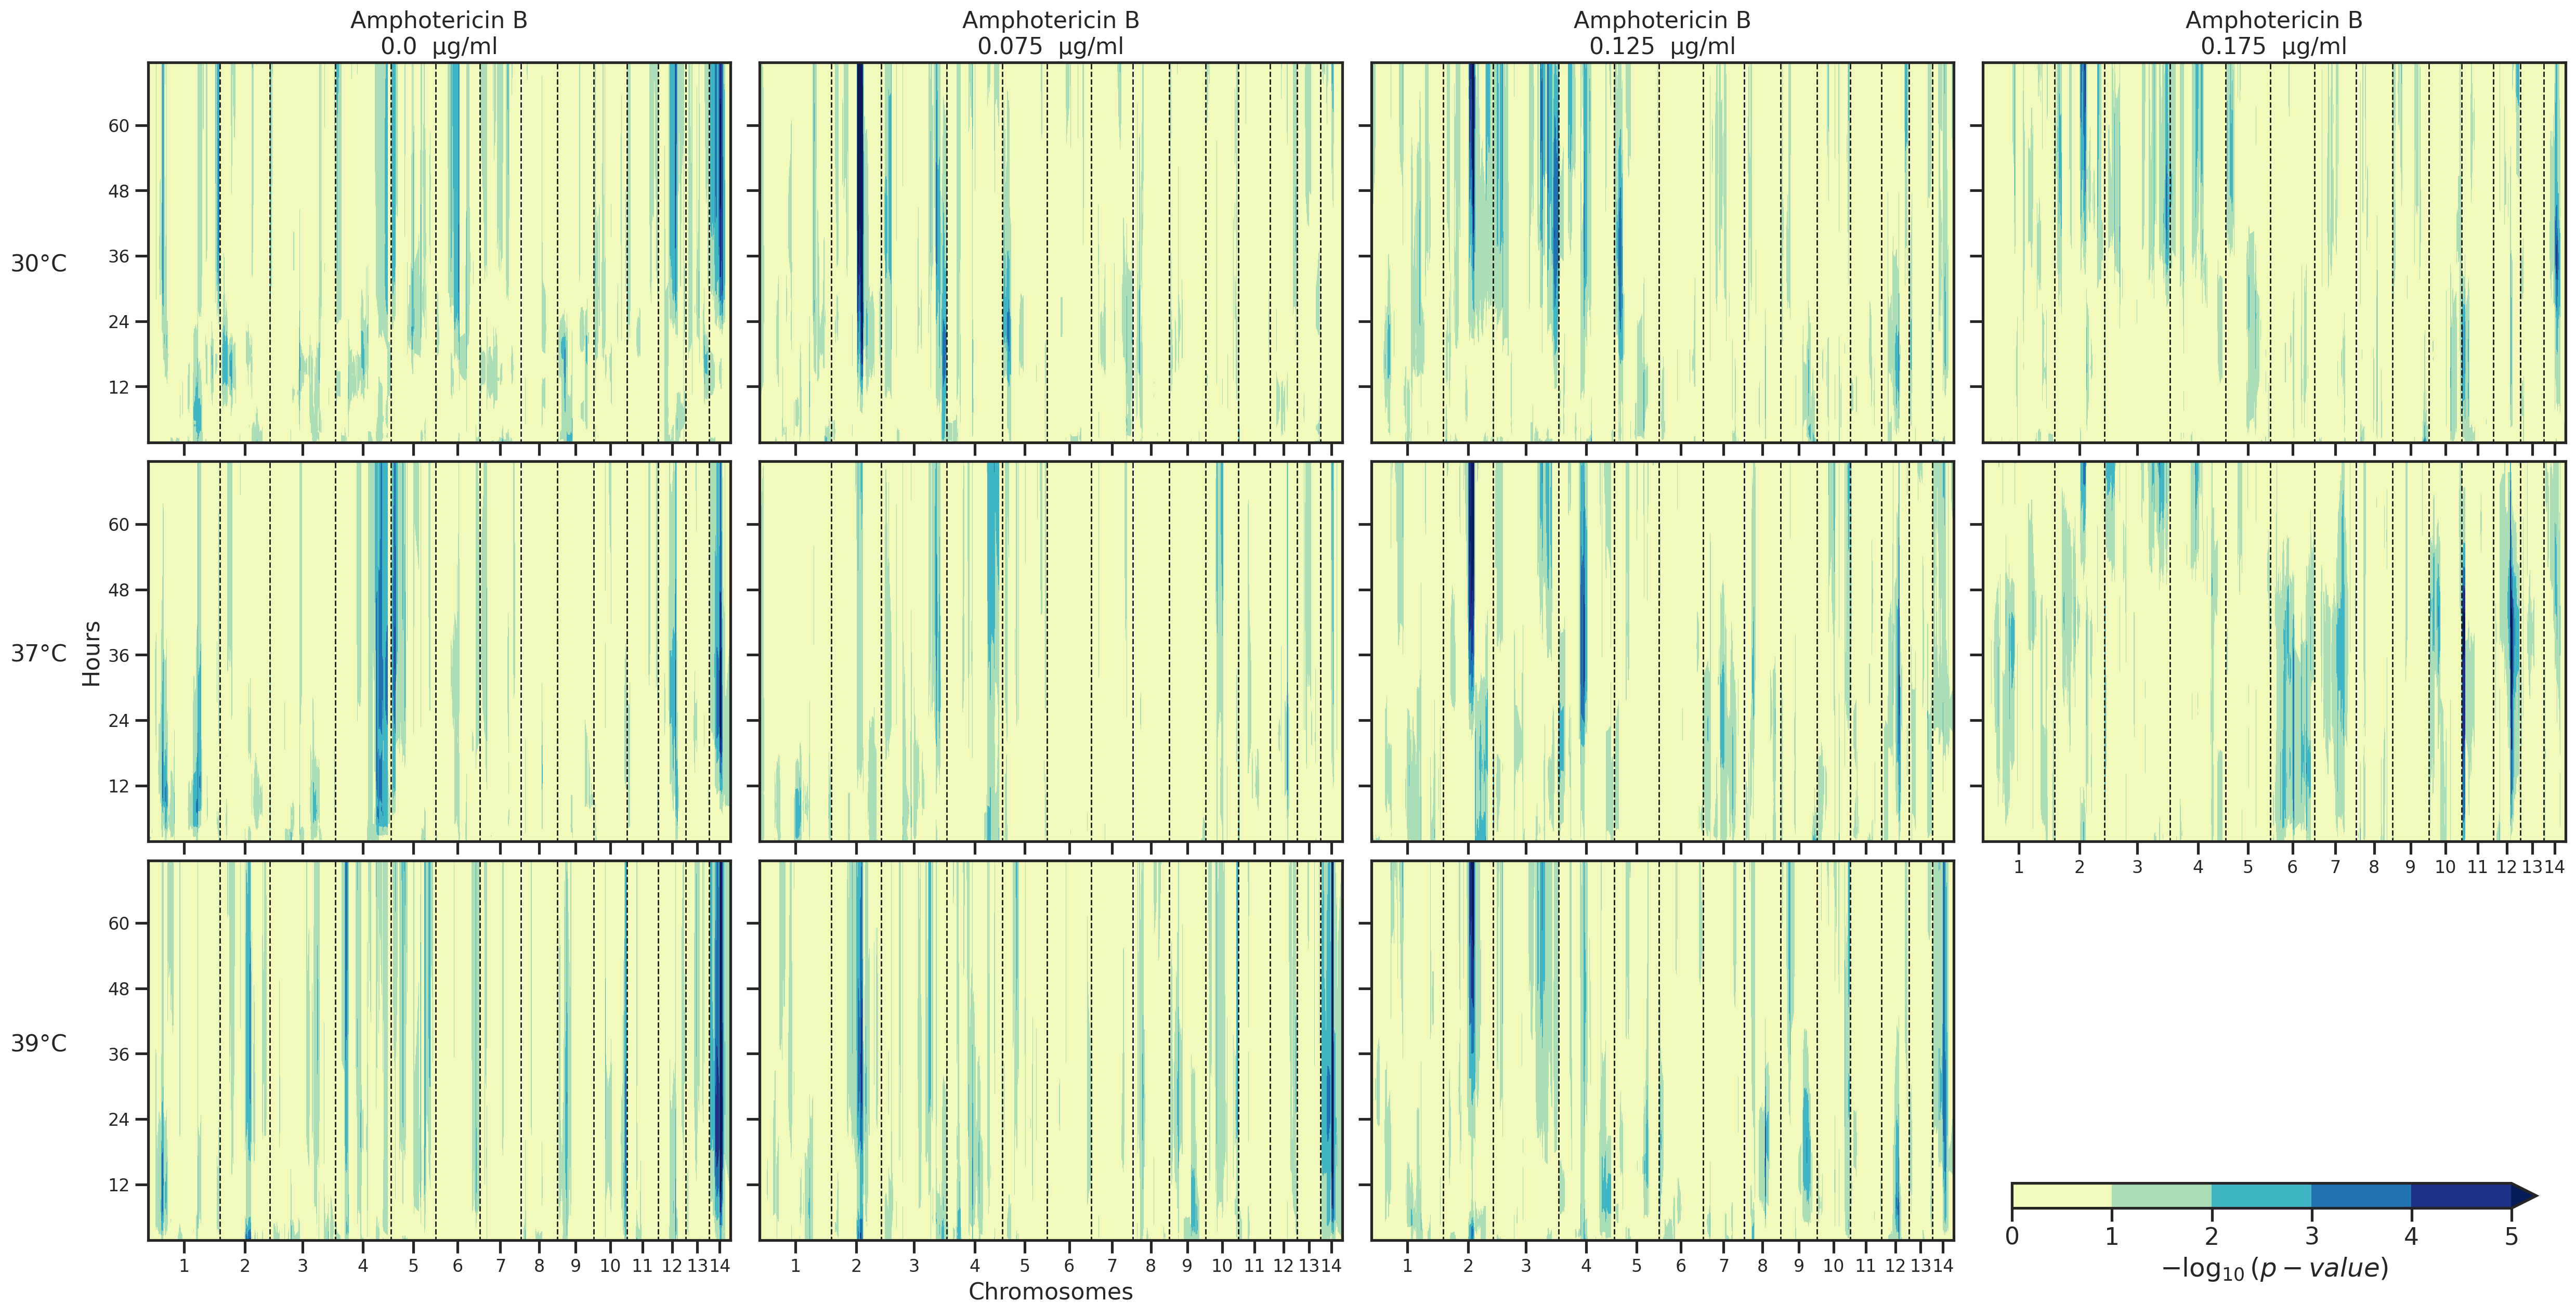

In [31]:
## Plot the association over time
mydpi= 200
fig, ax = plt.subplots(3,4,sharey=True,sharex=False,
                       figsize=(30,15),dpi=mydpi)
for i, td in condi.iterrows():
    for c,chrom in enumerate(chrlist):
        temp = qtlxt[(qtlxt.Temp==td.temp) & (qtlxt.AmphB==td.amphB) & 
            (qtlxt.Chrom==chrom)][times_ixs+['Pos']]
        chpos = temp.Pos.values + cumpos[c]
        cs = ax.ravel()[i].contourf(chpos,timex,temp[times_ixs].T.values,cmap="YlGnBu",
                                    levels=np.arange(thresholds['0.05'].max()),extend='max');
    if i in np.arange(4):
        plt.sca(ax.ravel()[i])
        plt.title('Amphotericin B\n' +str(td[1])+'  \u03BCg/ml' ,fontsize=16)
    ax.ravel()[i].vlines(np.array(clens) + np.array(cumpos),
                         0,np.max(timex),
           color='k',linewidth=1,linestyle='--');
    ax.ravel()[i].set_xticks(chrom_midpts);
    if i >= 7:
        ax.ravel()[i].set_xticklabels(np.arange(1,15),
                    fontsize=12)#,fontweight='bold');
    else:
        ax.ravel()[i].set_xticklabels([ ])
    
    ax.ravel()[i].set_yticks([12,24,36,48,60]);
    ax.ravel()[i].set_yticklabels([12,24,36,48,60],
                    fontsize=12);
plt.ylim(np.min(timex),np.max(timex))
fig.colorbar(cs, ax=ax[-1,-1], shrink=.9,
             label='$-\log_{10}\,(p-value)$',
             #orientation='vertical')
             orientation='horizontal');
ax[-1,-1].axis('off')
plt.subplots_adjust(wspace=0.05,hspace=0.05);
plt.sca(ax[-1,1])
plt.xlabel('Chromosomes',#fontweight='bold',
         size=16)

plt.sca(ax[1,0])
plt.ylabel('Hours',fontsize=16)#,fontweight='bold',size=14);
tl = 0.09

[fig.text(tl,0.75-(0.25*i),u'%s°C'%t,ha='center',va='center',
          fontsize=16)#,fontweight='bold') 
 for i,t in enumerate(temps)] 
#fig.savefig('%scdx_time_QTL_AUCdxt_contour_matrix.png'%(figpath),
plt.savefig('../FIGURES/SUPP/PDFs/S3_Fig.pdf',
            dpi=300,bbox_inches='tight');

In [32]:
## Bring in additional mods
import matplotlib.gridspec as gridspec
from matplotlib import cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
plt.style.use('tableau-colorblind10')

In [33]:
## sub set the od for the 37 degree data 
t = 37
d = 0.125
tempdf = df[(df.temp==t) & (df.amphB==d)]
tempdf.index= tempdf.strain
od_segs = tempdf.groupby(tempdf.index).agg('median')[times_ixs]
od_segs.shape

(104, 280)

/home/croth/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:88: UserWarning: Use the colorbar set_ticks() method instead.


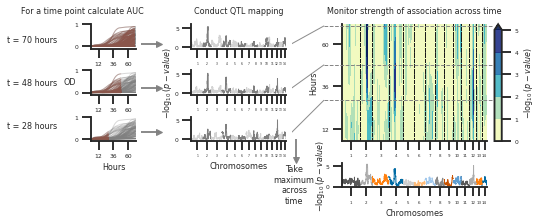

In [34]:
## Plot figure 4
fig = plt.figure(figsize=(7.1,3))
gs = fig.add_gridspec(4,8,hspace=.9,wspace=.12)
timesoi = [28,48,70][::-1]
fs = 8
for i, j in enumerate(timesoi):
    ax = fig.add_subplot(gs[i,0])
    plt.title('For a time point calculate AUC' if i == 0 else None,
              fontsize=fs,x=-.2,y=1.2)
    plt.plot(timex, od_segs[times_ixs].T[geno_strains],
             alpha=0.3,color='grey',linewidth=1)
    plt.plot(timex[:timex.index(j)],
         od_segs[times_ixs[:timex.index(j)]].T[geno_strains],
             alpha=0.4,color='tab:brown',linewidth=1)#pcolors[i])
    plt.ylim(-0.1,1);plt.xlim(0,72);
    plt.xticks([12,36,60],fontsize=fs-2)
    plt.xlabel('Hours' if i == 2 else None,fontsize=fs)
    #plt.ylabel('OD' if i == 1 else None,fontsize=fs)
    plt.text(-35,0.5,s='OD' if i == 1 else None,
             fontsize=fs,rotation=0,va='center',ha='center')
    [ax.spines[k].set_visible(False)  
             for k in ['top','right']];
    plt.yticks([0,1],fontsize=fs-2)
    
for i, j in enumerate(timesoi):
    ax = fig.add_subplot(gs[i,2:4])
    plt.title('Conduct QTL mapping' if i == 0 else None,
              fontsize=fs,x=.5,y=1.2)
    for c,chrom in enumerate(chrlist):
        temp = qtlxt[(qtlxt.Temp== t) & 
                 (qtlxt.AmphB== d) & 
                 (qtlxt.Chrom==chrom)
                ][[times_ixs[timex.index(j)]]+['Pos']]
        chpos = temp.Pos.values + cumpos[c]
        plt.plot(chpos,temp[times_ixs[timex.index(j)]],
                 color='lightgrey' if c%2==0 else 'tab:grey',linewidth=1)
    plt.xticks(chrom_midpts,labels=np.arange(1,15),fontsize=fs-5)
    plt.ylim(-0.5,6)

    #plt.ylabel('$-\log_{10}\,(p-value)$' if i == 1 else None,fontsize=fs)
    
    plt.text(x=-0.25,y=0.5,s='$-\log_{10}\,(p-value)$' if i == 1 else None,
         transform=ax.transAxes,
         va='center',ha='center',
         fontsize=fs,rotation=90)
    
    plt.xlabel('Chromosomes' if i == 2 else None, fontsize=fs)
    [ax.spines[k].set_visible(False)  
             for k in ['top','right']];
    plt.xlim(0,temp.Pos.max()+cumpos[c])
    plt.yticks([0,5],fontsize=fs-2)
    
## ----------------------- QTL heat map plot ---------------------- ##
ax = fig.add_subplot(gs[:-1,-3:])
plt.title('Monitor strength of association across time',
          x=.5,y=1.04,fontsize=fs)
for c,chrom in enumerate(chrlist):
    temp = qtlxt[(qtlxt.Temp== t) & (qtlxt.AmphB== d) & 
        (qtlxt.Chrom==chrom)][times_ixs+['Pos']]
    chpos = temp.Pos.values + cumpos[c]
    cs = ax.contourf(chpos,timex,temp[times_ixs].T.values,cmap="YlGnBu",
                        levels=np.arange(thresholds['0.05'].max()),
                     extend='max',alpha=0.9);

    plt.vlines(np.array(clens) + np.array(cumpos),
                1.75,np.max(timex),
               color='k',linewidth=1,linestyle='--');
    plt.xticks(chrom_midpts, labels = np.arange(1,15), fontsize=fs-4)
    [ax.spines[k].set_visible(False)  
             for k in ['top','right']];
#plt.ylim(71,5)
plt.ylim(5,71)
plt.yticks([12,36,60],fontsize=fs-2)
plt.xlim(0,temp.Pos.max() + np.max(cumpos))
plt.ylabel('Hours',fontsize=fs)

## ----------------- Add color bar ----------------------- ##
axins = inset_axes(ax,
           width="5%", # width = 10% of parent_bbox width
           height="100%", # height : 50%
           loc=6,
           bbox_to_anchor=(1.05, 0., 1, 1),
           bbox_transform=ax.transAxes,
           borderpad=0,)

cbar = plt.colorbar(cs, cax=axins)
plt.ylabel('$-\log_{10}\,(p-value)$',fontsize=fs)
plt.yticks(np.arange(6),fontsize=fs-2)

## ----------- Lines connecting the qtl maps to heat map -------- ##
line_pts = np.array([10,35,60])
ax = fig.add_subplot(gs[:-1,4])
plt.ylim(5,71)
plt.xlim(0,.7)
plt.plot([0,.5],
         np.array(list(zip(line_pts,np.array(timesoi[::-1])))).T,
         color='k',alpha=.5,linewidth=1)
plt.axis('off')

## ------------------------- Curves to QTL ---------------------- ##
ax = fig.add_subplot(gs[:-1,1])
plt.ylim(5,71)
plt.xlim(0,1.5)
plt.plot([0,.6],
         np.array(list(zip(line_pts,line_pts))).T,
         color='k',alpha=.5,linewidth=2)
plt.plot(.6*np.ones(len(timesoi)),line_pts,'>',
         color='grey',alpha=.95,ms=6)
plt.axis('off')

## ------------------------- Draw dashed lines -------------- ##
fig.add_axes([0.565,0.333,0.36,0.546]);
u=1.     #x-position of the center
a=2.     #radius on the x-axis
b=1.4    #radius on the y-axis
for v in np.array(timesoi)+np.array([0,0.3,0.5]):
    plt.hlines(v,0,1,linestyle='--',linewidth=1,
               color='grey',alpha=0.95)
plt.ylim(5,71)
plt.axis('off')


ax = fig.add_subplot(gs[-1,-3:])
for c,chrom in enumerate(chrlist[::-1]):
    ci = int(chrom[-2:])-1
    temp = qtlxt[(qtlxt.Temp== t) & (qtlxt.AmphB== d) & 
        (qtlxt.Chrom==chrom)][['Max','Pos']]
    chpos = temp.Pos.values + cumpos[ci]
    plt.plot(chpos,temp.Max,linewidth=1)
[ax.spines[k].set_visible(False) for k in ['top','right']];
plt.xticks(chrom_midpts,labels=np.arange(1,15),fontsize=fs-4)
plt.xlim(0,qtlxt[(qtlxt.Chrom=='Chr14')].Pos.max() + np.max(cumpos))

plt.yticks([0,5],fontsize=fs-2)
#plt.ylabel('$-\log_{10}\,(p-value)$',fontsize=fs)
plt.text(x=-0.15,y=0.5,s='$-\log_{10}\,(p-value)$',
         transform=ax.transAxes,
         va='center',ha='center',
         fontsize=fs,rotation=90)

plt.xlabel('Chromosomes',fontsize=fs);
plt.text(-0.33,0.11,'Take\nmaximum\nacross\ntime',
         fontsize=fs,transform=ax.transAxes,
         va='center',ha='center')

tx = 0.01
ty = [.81,.61,.41]

[fig.text(tx,ty[i],'t = %s hours'%(tpt),
          fontsize=fs,ha='center',va='center')
 for i,tpt in enumerate(timesoi)];



fig.add_axes([0.51,0.2,0.03,0.15]);
plt.plot([0.5,0.5],[0.5,1],color='k',alpha=0.5,linewidth=2)
plt.plot([0.5],[0.5],'v',color='grey',alpha=0.95,ms=6)
plt.ylim([0.25,1])
plt.axis('off')

mydpi = 600

plt.savefig('../FIGURES/MAIN/PDFs/Fig4.pdf',
            dpi=mydpi,bbox_inches='tight')

plos_save = '../FIGURES/MAIN/TIFF/Fig4.tiff'
plt.savefig(plos_save,
            dpi=mydpi,bbox_inches='tight');


im = Image.open(plos_save)
w,h = im.size
assert w/mydpi > 2.63
assert w/mydpi < 7.5
assert h/mydpi < 8.5
im.save(plos_save,compression='tiff_lzw')

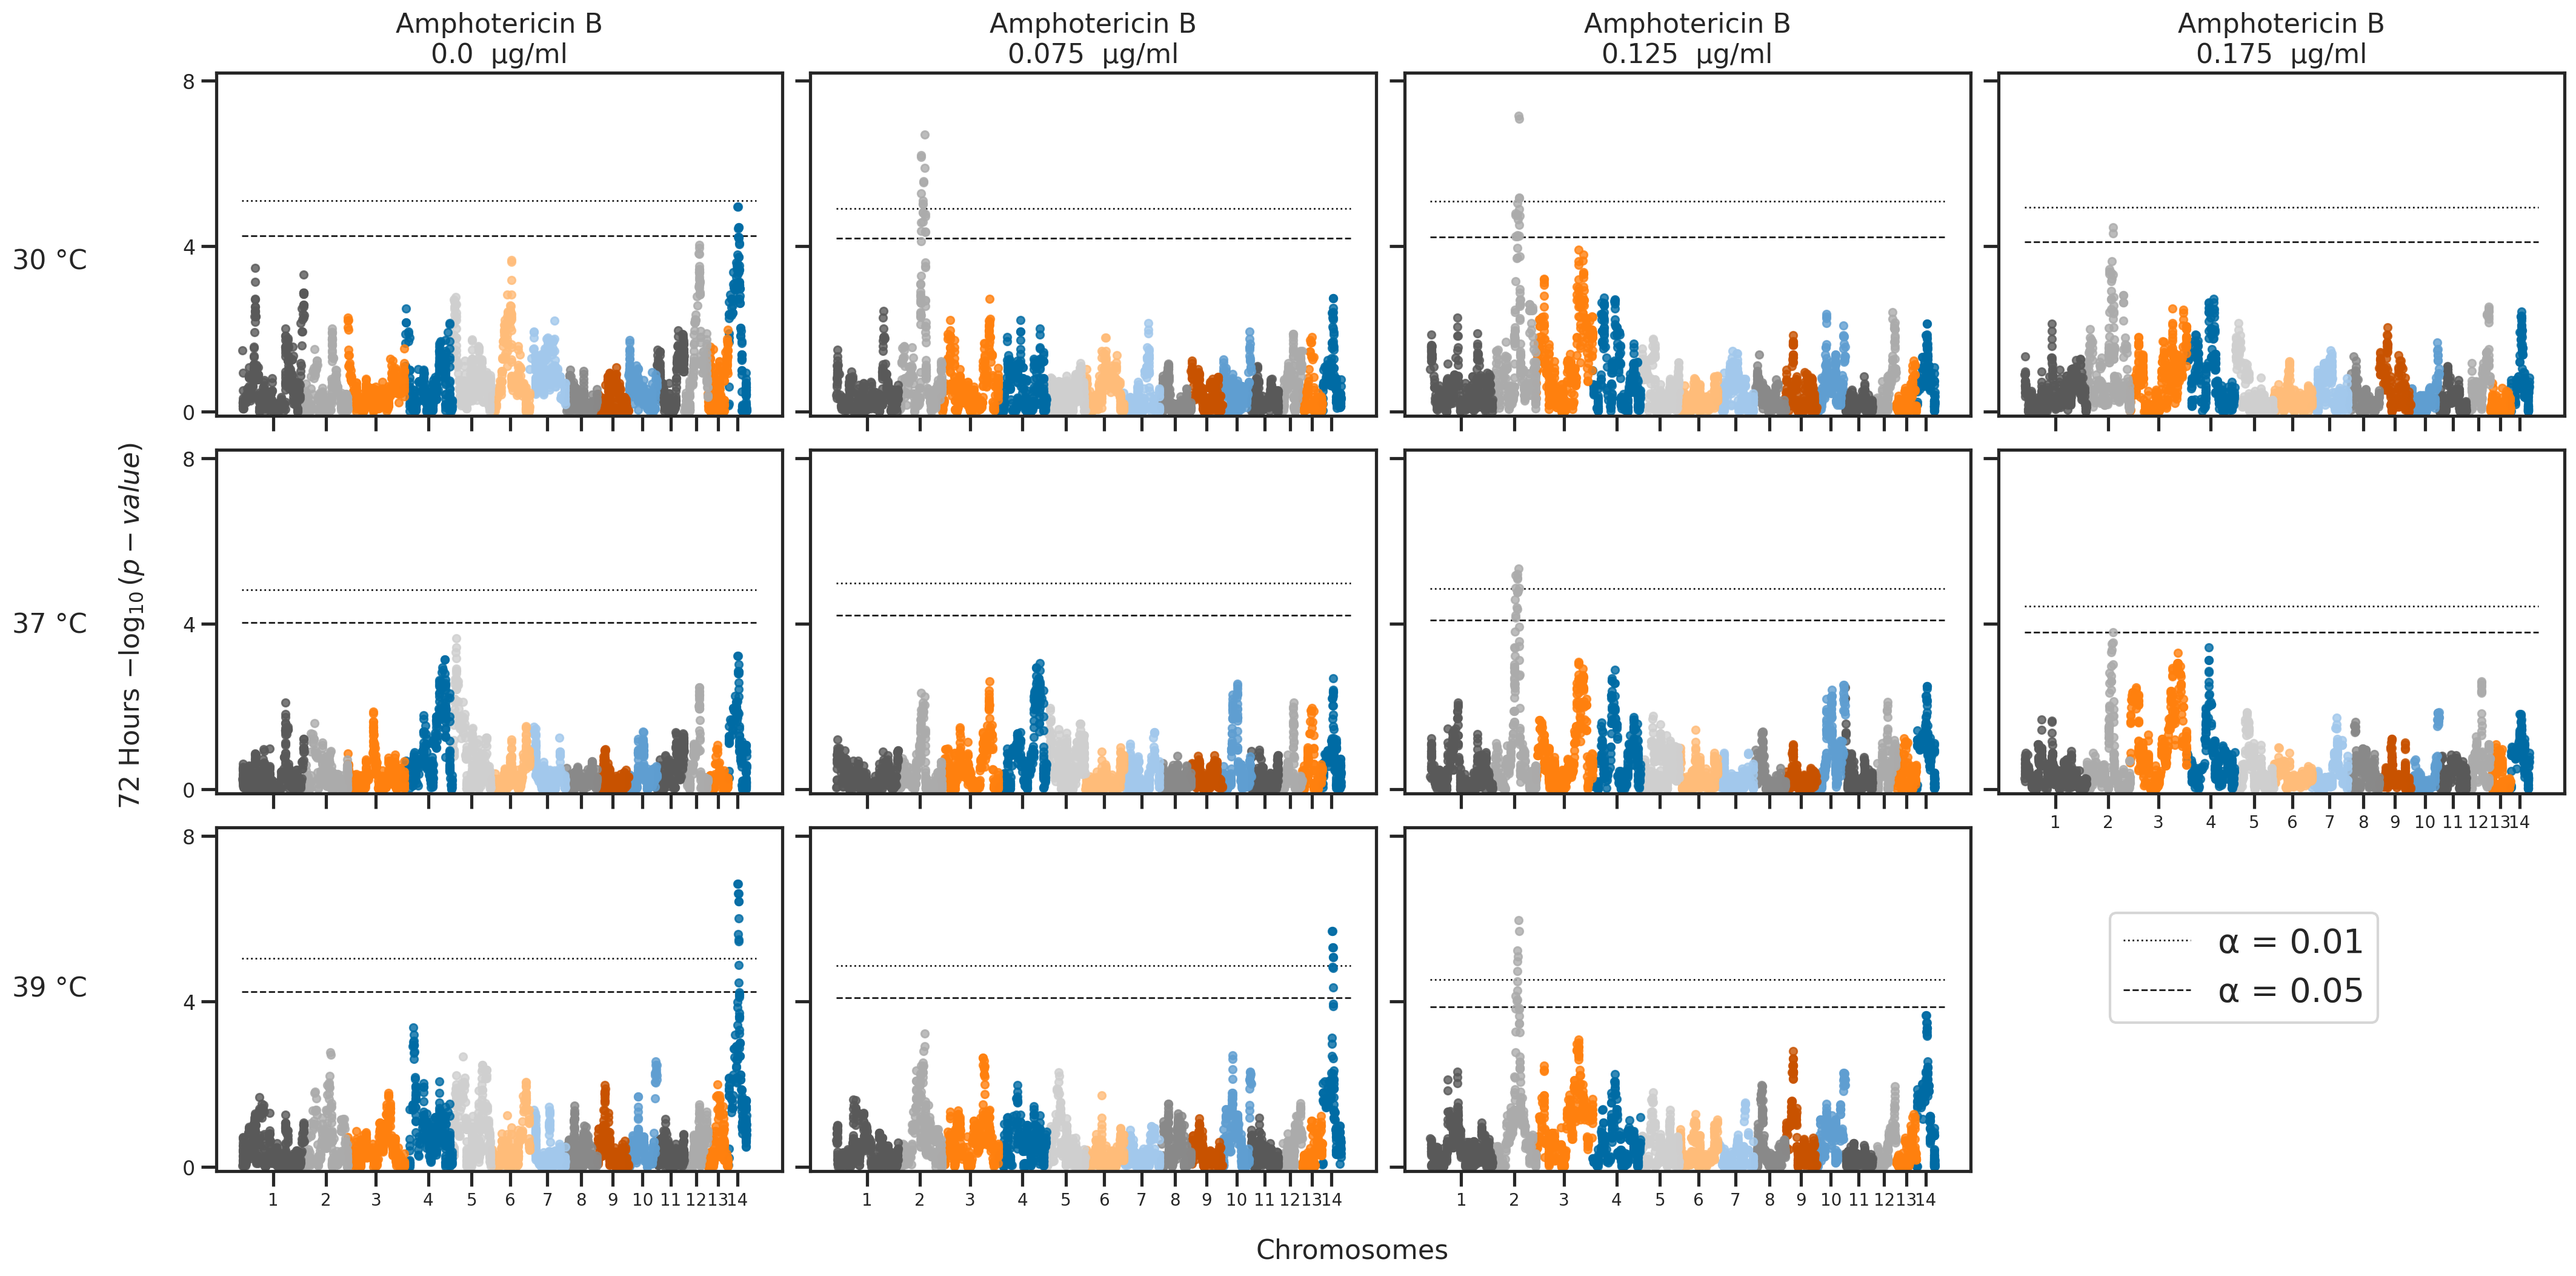

In [35]:
## Plot supplementary figure 6
mydpi=200
fig, ax = plt.subplots(3,4,sharey=True,sharex=False,
                       figsize=(25,12),dpi=mydpi)
for i, td in condi.iterrows():
    plt.sca(ax.ravel()[i])
    for c,chrom in enumerate(chrlist[::-1]):
        
        c = 13 - c
        
        temp_mm = qtlxt[(qtlxt.Temp==td.temp) & 
                         (qtlxt.AmphB==td.amphB) & 
                        (qtlxt.Chrom==chrom)][[times_ixs[-1],'Pos']]
    
        
        plt.plot(temp_mm.Pos.values+cumpos[c],
                 temp_mm[times_ixs[-1]].values,'.',alpha=.8)
                 #label='Max' if (i == 8) and c ==13 else None)
      
    ax.ravel()[i].set_xticks(chrom_midpts);
    ax.ravel()[i].set_yticks(np.arange(0,12,4));
    ax.ravel()[i].set_yticklabels(np.arange(0,12,4),
                                  fontsize=12)#,fontweight='bold');
    
    thres = thresholds[(thresholds.Temp==td[0]) & 
                       (thresholds.Amphb==td[1]) & 
                       (thresholds.Stat=='Last')][['0.01','0.05']].T.values
    
    [plt.hlines(a,0,19*(10**6),color='k',
                linestyle= sigs_ls[z],
                label = sig_labs[z] if i == 10 else None,
                linewidth=1) for z,a in enumerate(thres)]

    plt.ylim(-0.1,8.2)
    if i in np.arange(7,11):
        ax.ravel()[i].set_xticklabels(np.arange(1,15),fontsize=10)
    else:
        ax.ravel()[i].set_xticklabels([' ' for n in range(14)])

ax[-1,-1].axis('off') ## Turn off last unused axis
plt.subplots_adjust(wspace=0.05,hspace=0.1);
fig.text(0.5,0.07,'Chromosomes',#,fontweight='bold',
         size=16,va='center',ha='center');

fig.text(0.102,0.5,u'72 Hours $-\log_{10}\,(p-value)$\n',
         size=16,va='center',ha='center',rotation=90);

[fig.text(0.07,0.75-(0.25*i),u'%s °C'%(t),
             ha='center',va='center',
            fontsize=16)#,fontweight='bold') 
         for i,t in enumerate(temps)];

for i,d in enumerate(drugs):
    plt.sca(ax[0,i])
    plt.title('Amphotericin B\n' +str(d)+'  \u03BCg/ml' ,fontsize=16)

plt.sca(ax[-1,-2])
plt.legend(bbox_to_anchor=[1.75,0.8],fontsize=14,prop={'size':20})
#fig.savefig('%scdx_time_QTL_AUCdxt_Last_matrix.png'%(figpath),
plt.savefig('../FIGURES/SUPP/PDFs/S6_Fig.pdf',
          dpi=300,bbox_inches='tight');

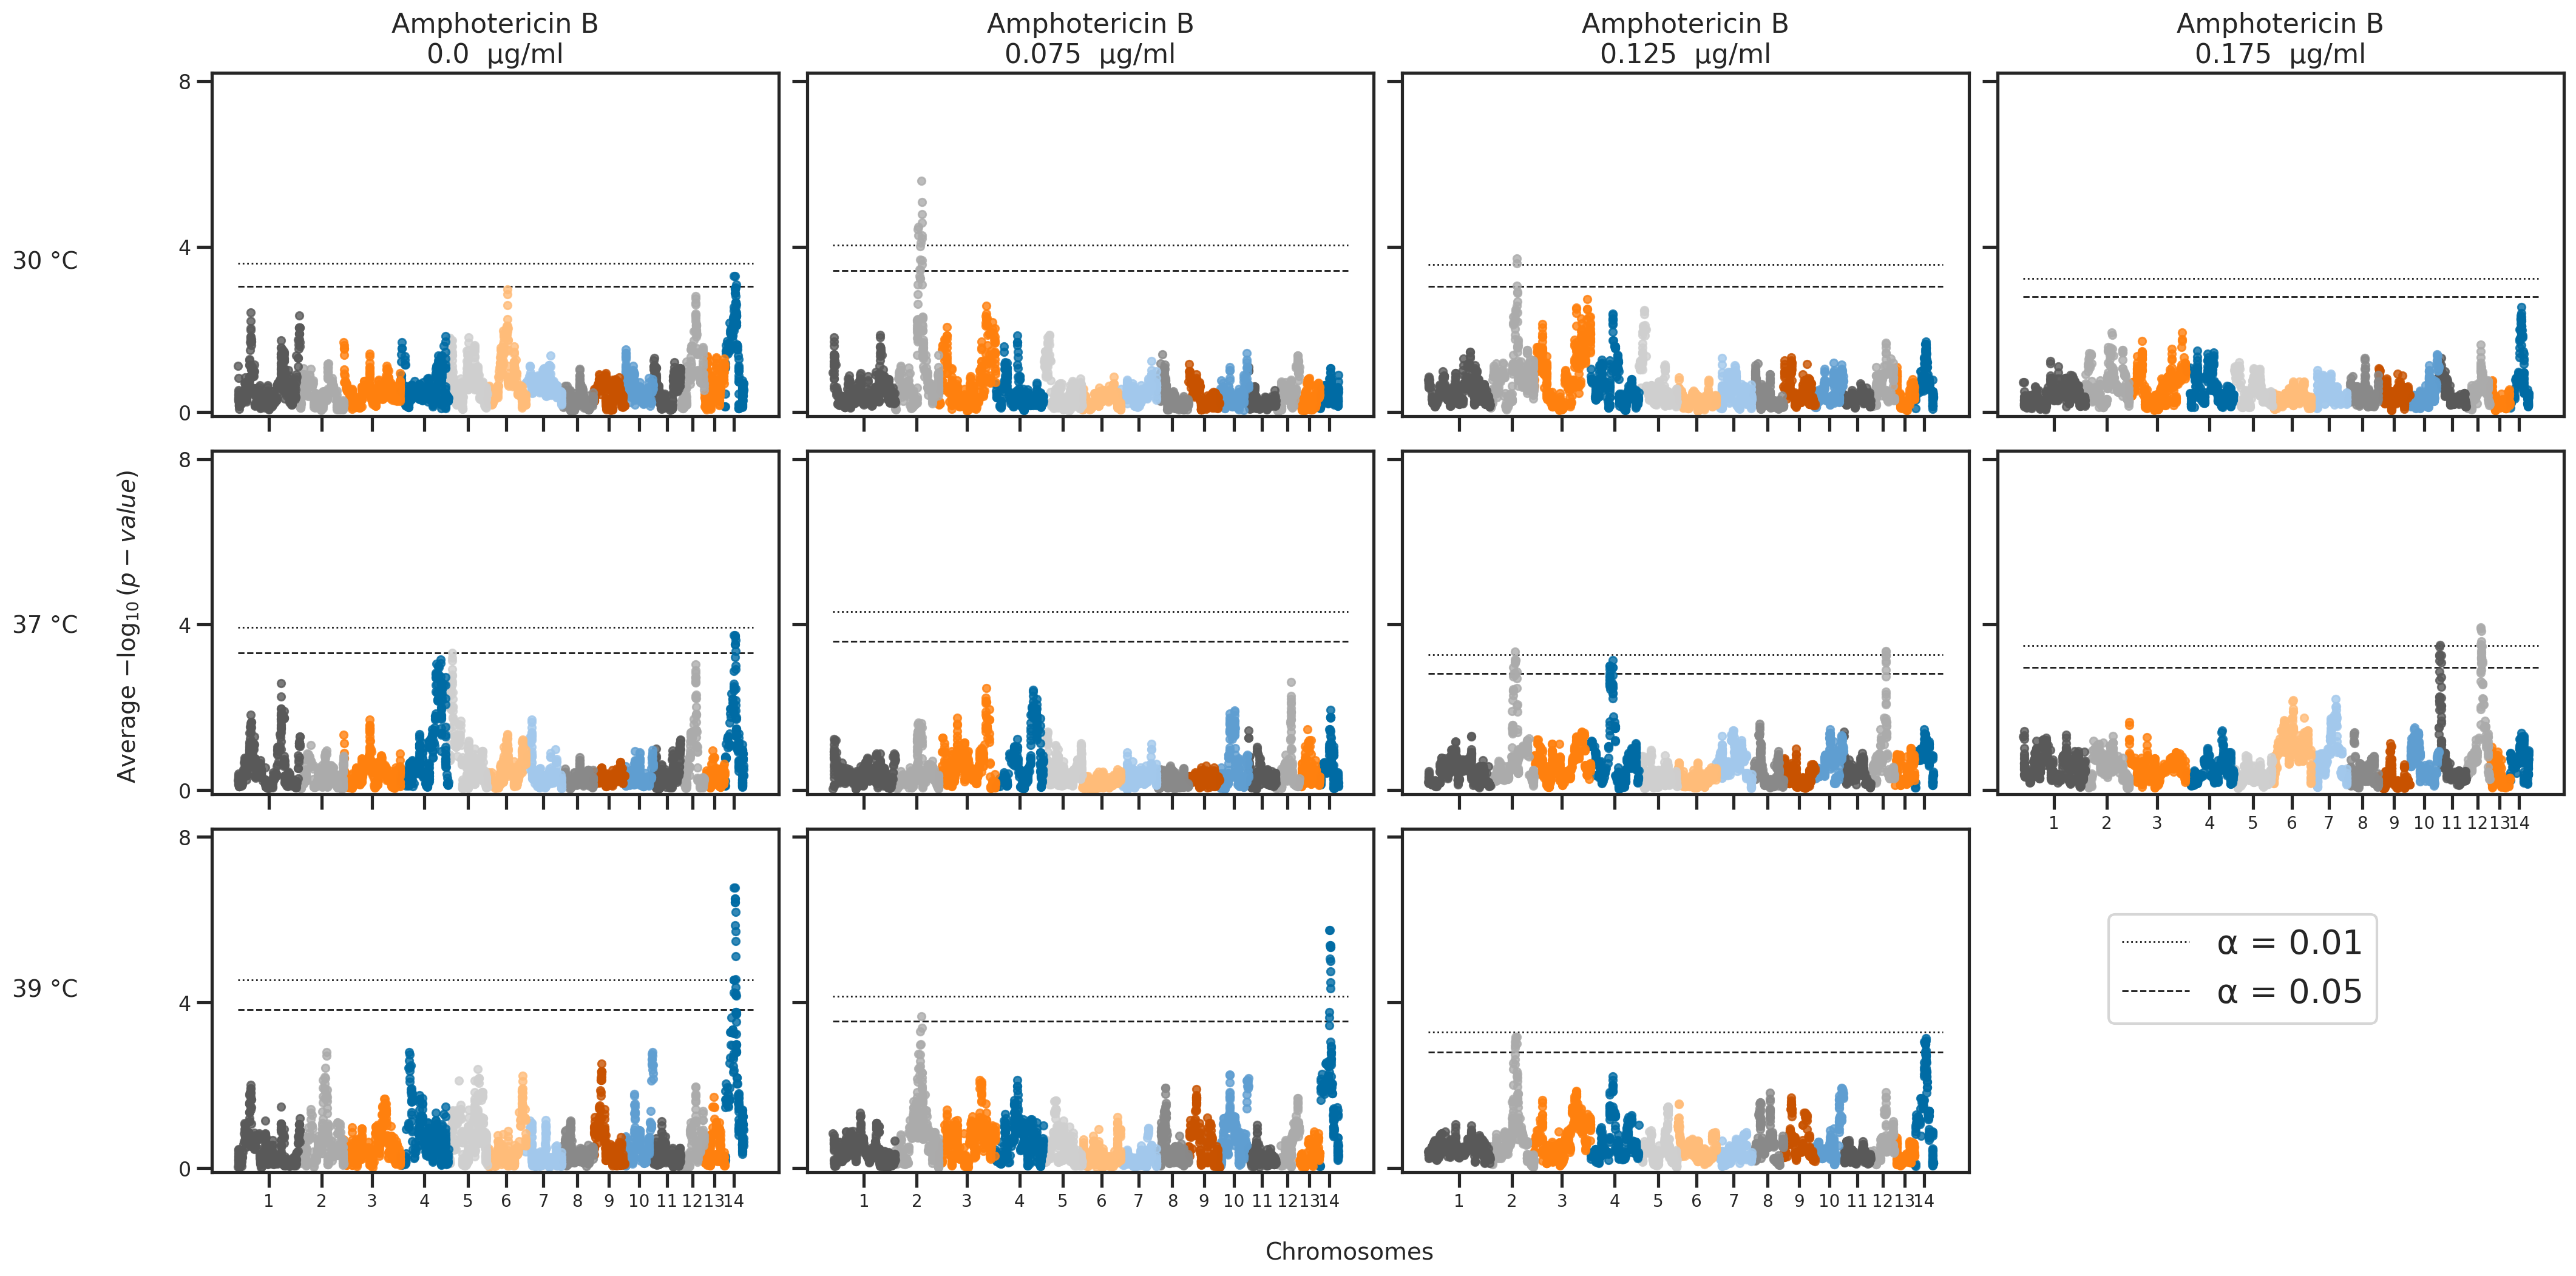

In [36]:
## Plot supplementary figure 4
fig, ax = plt.subplots(3,4,sharey=True,sharex=False,
                       figsize=(25,12),dpi=mydpi)
for i, td in condi.iterrows():
    plt.sca(ax.ravel()[i])
    for c,chrom in enumerate(chrlist[::-1]):
        c = 13 - c
        temp_mm = qtlxt[(qtlxt.Temp==td.temp) & 
                         (qtlxt.AmphB==td.amphB) & 
                        (qtlxt.Chrom==chrom)][['Mean','Pos']]
    
        
        plt.plot(temp_mm.Pos.values+cumpos[c],temp_mm.Mean.values,'.',alpha=.8)
      
    ax.ravel()[i].set_xticks(chrom_midpts);
    ax.ravel()[i].set_yticks(np.arange(0,12,4));
    ax.ravel()[i].set_yticklabels(np.arange(0,12,4),
                                  fontsize=12)
    thres = thresholds[(thresholds.Temp==td[0]) & 
                       (thresholds.Amphb==td[1]) & 
                       (thresholds.Stat=='Mean')][['0.01','0.05']].T.values
    [plt.hlines(a,0,19*(10**6),color='k',
                linestyle= sigs_ls[z],
                label = sig_labs[z] if i == 10 else None,
                linewidth=1) for z,a in enumerate(thres)]

    plt.ylim(-0.1,8.2)
    if i in np.arange(7,11):
        ax.ravel()[i].set_xticklabels(np.arange(1,15),fontsize=10)
    else:
        ax.ravel()[i].set_xticklabels([' ' for n in range(14)])

ax[-1,-1].axis('off') ## Turn off last unused axis
plt.subplots_adjust(wspace=0.05,hspace=0.1);
fig.text(0.5,0.07,'Chromosomes',
         size=14,va='center',ha='center');

fig.text(0.102,0.5,u'Average $-\log_{10}\,(p-value)$\n',
         size=14,va='center',ha='center',rotation=90);

[fig.text(.07,0.75-(0.25*i),u'%s °C'%(t),
             ha='center',va='center',
            fontsize=14) for i,t in enumerate(temps)];

for i,d in enumerate(drugs):
    plt.sca(ax[0,i])
    plt.title('Amphotericin B\n' +str(d)+'  \u03BCg/ml' ,fontsize=16)

plt.sca(ax[-1,-2])
plt.legend(bbox_to_anchor=[1.75,0.8],fontsize=14,prop={'size':20})
plt.savefig('../FIGURES/SUPP/PDFs/S4_Fig.pdf',
          dpi=300,bbox_inches='tight');

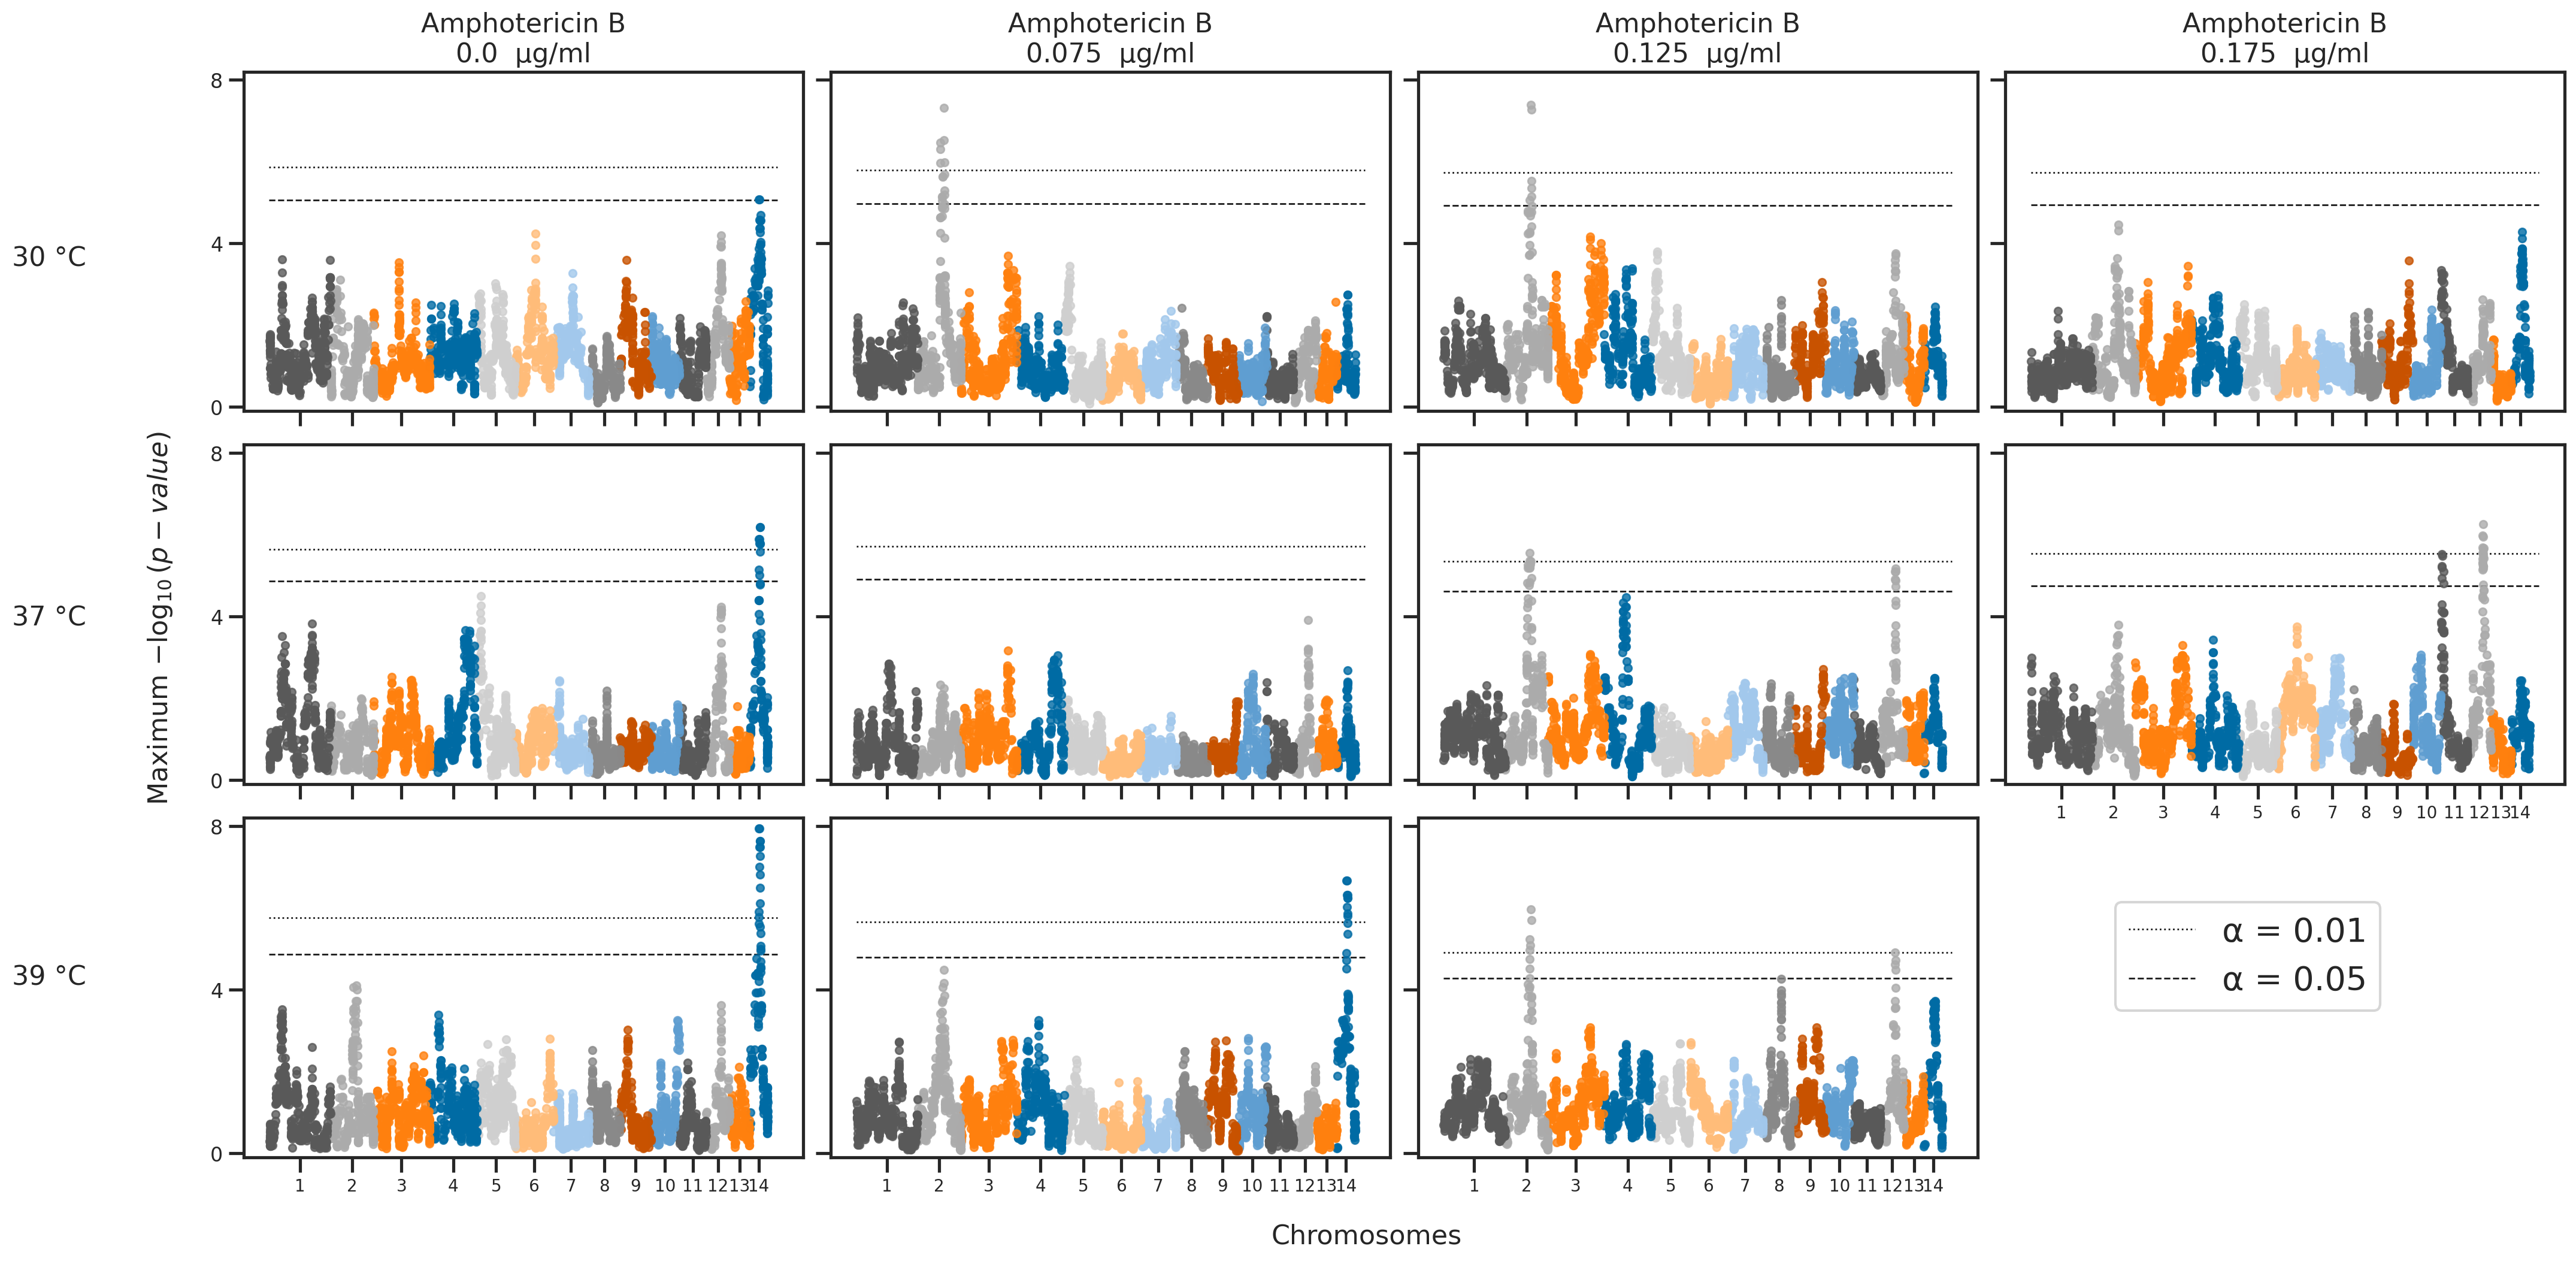

In [37]:
## Plot supplementary figure 
mydpi=200
fig, ax = plt.subplots(3,4,sharey=True,sharex=False,
                       figsize=(25,12),dpi=mydpi)
for i, td in condi.iterrows():
    plt.sca(ax.ravel()[i])
    for c,chrom in enumerate(chrlist[::-1]):
        c = 13 - c
        temp_mm = qtlxt[(qtlxt.Temp==td.temp) & 
                         (qtlxt.AmphB==td.amphB) & 
                        (qtlxt.Chrom==chrom)][['Max','Pos']]
    
        
        plt.plot(temp_mm.Pos.values+cumpos[c],temp_mm.Max.values,'.',alpha=.8,
                 label='Max' if (i == 8) and c ==13 else None)
      
    ax.ravel()[i].set_xticks(chrom_midpts);
    ax.ravel()[i].set_yticks(np.arange(0,12,4));
    ax.ravel()[i].set_yticklabels(np.arange(0,12,4),
                                  fontsize=12)
    thres = thresholds[(thresholds.Temp==td[0]) & 
                       (thresholds.Amphb==td[1]) & 
                       (thresholds.Stat=='Max')][['0.01','0.05']].T.values
    [plt.hlines(a,0,19*(10**6),color='k',
                linestyle= sigs_ls[z],
                label = sig_labs[z] if i == 10 else None,
                linewidth=1) for z,a in enumerate(thres)]

    plt.ylim(-0.1,8.2)
    if i in np.arange(7,11):
        ax.ravel()[i].set_xticklabels(np.arange(1,15),
                fontsize=10)
    else:
        ax.ravel()[i].set_xticklabels([' ' for n in range(14)])

ax[-1,-1].axis('off') 
plt.subplots_adjust(wspace=0.05,hspace=0.1);
fig.text(0.5,0.07,'Chromosomes',
         size=16,va='center',ha='center');

fig.text(0.102,0.5,u'Maximum $-\log_{10}\,(p-value)$\n',
        size=16,va='center',ha='center',rotation=90);

[fig.text(.06,0.75-(0.25*i),u'%s °C'%(t),
             ha='center',va='center',
            fontsize=16) for i,t in enumerate(temps)];

for i,d in enumerate(drugs):
    plt.sca(ax[0,i])
    plt.title('Amphotericin B\n' +str(d)+'  \u03BCg/ml' ,fontsize=16)

plt.sca(ax[-1,-2])
plt.legend(bbox_to_anchor=[1.75,0.8],fontsize=14,prop={'size':20})
plt.savefig('../FIGURES/SUPP/PDFs/S5_Fig.pdf',
          dpi=300,bbox_inches='tight');

In [38]:
## Take maximum
temp_max = qtlxt[(qtlxt.Temp.isin([30,37,39])) & 
                 (qtlxt.AmphB==0.0)].groupby(
    ['Chrom','Pos'])['Max'].agg(np.max).reset_index()

In [39]:
## 0.125 ug / ml of amph. B at 37
temp_drug = qtlxt[(qtlxt.Temp==37) & 
                (qtlxt.AmphB==0.125)
                 ][['Max','Chrom','Pos']]

In [40]:
## Find chromosome 12 max association
ch12ix = temp_drug[(temp_drug.Chrom=='Chr12')].Max.idxmax()
print('Index of chromosome %s'%(ch12ix))
ch12ix_max = qtlxt[(qtlxt.Temp==37.0) & (qtlxt.AmphB==0.125) & 
      (qtlxt.Chrom=='Chr12')].T[[ch12ix]].T[times_ixs].T.astype(float).idxmax().max()
print('Time index of max %s'%(ch12ix_max))

Index of chromosome 82669
Time index of max 106200s


In [41]:
## Chromosome 2
ch02ix = temp_drug[(temp_drug.Chrom=='Chr02')].Max.idxmax()
print('Index of chromosome %s'%(ch02ix))
ch02ix_max = qtlxt[(qtlxt.Temp==37.0) & (qtlxt.AmphB==0.125) & 
      (qtlxt.Chrom=='Chr02')].T[[ch02ix]].T[times_ixs].T.astype(float).idxmax().max()
print('Time index of max %s'%(ch02ix_max))

Index of chromosome 15339
Time index of max 202500s


In [42]:
## Get the genotypes are chrome 02 and 12 qtl
ch12qtl = geno_df.T[ch12ix].T[geno_strains]
ch02qtl = geno_df.T[ch02ix].T[geno_strains]

In [43]:
## Take maximum
qtlmaxt = qtlxt.groupby('Cumpos')[['Chrom','Max']].agg(max)
qtlmaxt.reset_index(inplace=True)

In [44]:
## Bring in other mods
import statsmodels.formula.api as smf
from matplotlib.gridspec import GridSpec

In [45]:
## Set the significant thresholds
sig_chroms = ['Chr02','Chr11','Chr12','Chr14']

In [46]:
## Find the chromosome max
chrom_max = pd.DataFrame(qtlmaxt[(qtlmaxt.Chrom.isin(sig_chroms))].groupby('Chrom')['Max'].max())
chrom_max.reset_index(inplace=True)
chrom_max

Chrom       Max
0  Chr02  7.392040
1  Chr11  5.520205
2  Chr12  6.261549
3  Chr14  7.944399

In [47]:
## Gather time of maximal associaiton
qtlxt['Maxtime'] = [j.T.idxmax() for i,j in qtlxt[times_ixs].iterrows()]

In [48]:
## summarize these results
qtlmax_info = pd.concat([qtlxt[(qtlxt.Chrom==chrom_max.values[i][0]) & 
       (qtlxt.Max == chrom_max.values[i][1])][
    ['Temp','AmphB','Chrom','Block','Max','Maxtime']].iloc[[-1],:] 
           for i in range(len(chrom_max))])

## Append max hour
qtlmax_info['Maxhour'] = [ np.round(float(a[:-1])/(60**2),2) 
                          for a in qtlmax_info.Maxtime]
qtlmax_info

Temp  AmphB  Chrom  Block       Max  Maxtime  Maxhour
15560  30.0  0.125  Chr02    533  7.392040  233100s    64.75
75313  37.0  0.175  Chr11   2508  5.520205  143100s    39.75
82942  37.0  0.175  Chr12   2792  6.261549  134101s    37.25
90473  39.0  0.000  Chr14   3018  7.944399  104401s    29.00

In [49]:
## Set dataframe index to the strain
df.index = df.strain

In [50]:
## Find the max associated auc
qtlmax_AUC = pd.concat([(df[(df.temp == r.Temp) & 
     (df.amphB == r.AmphB)].groupby(df[(df.temp == r.Temp) & 
                                       (df.amphB == float(r.AmphB))].index)[times_ixs
                ].cumsum(axis=1).groupby(df[(df.temp == r.Temp) & 
                        (df.amphB == r.AmphB)].index).agg(np.median)*dx)[r.Maxtime]
 for i,r in qtlmax_info.iterrows()],axis=1)

## print its shape
## should be number of prgeny x number of QTL
qtlmax_AUC.shape

(104, 4)

In [51]:
## View the first few rows
qtlmax_AUC.head()

233100s   143100s   134101s   104401s
strain                                          
SS-A837   1.453600  0.251375  0.232625  2.059625
SS-B307   9.924525  0.011500  0.009000  2.669750
SS-B310   0.645250  0.083400  0.074150  0.001550
SS-B311  31.290475  0.363325  0.359825  2.226500
SS-B312   2.573040  0.107575  0.102325  1.137000

In [52]:
## Find the maximumly associated genotypes per segregant
qtlmax_gv = pd.concat([genoxdf[(genoxdf.Block==b)][geno_strains].T 
                       for b in qtlmax_info.Block],axis=1)

## View first few rows
qtlmax_gv.head()

15560  75313  82942  90473
SS-B407        1.0    0.0    1.0    0.0
SS-B316        0.0    1.0    1.0    1.0
SS-B898_cor    0.0    0.0    0.0    1.0
SS-B369        0.0    0.0    1.0    0.0
SS-B997        1.0    1.0    1.0    0.0

In [53]:
## Bring in another needed mod
from matplotlib.ticker import MaxNLocator

In [54]:
## Define candidate genes
can_genes = ['SSK1',' ','SSK2','RIC8']

In [55]:
## Find max position
xmax = geno_df[(geno_df.Chrom=='Chr14')].Pos.max() + np.max(cumpos)

In [56]:
## Take max association by genotype
qtlxtix = pd.concat([a[1].max() 
                     for a in qtlxt.groupby(qtlxt.index)],axis=1).T

## Set loci
qtlxtix.index = loci_ix

## What is the shape?
## Should be genetic loci by time
qtlxtix.shape

(3108, 289)

In [57]:
## View first few rows
qtlxtix.head()

6300s    7201s    8100s    9000s     9901s    10800s    11700s  \
0    1.61684  1.44237  1.32312   1.2146   1.07487  0.981114  0.908134   
232  1.70141  1.50473  1.40224  1.31514   1.18486   1.09092   1.00989   
249    1.564  1.39801  1.30798  1.21762   1.08391   1.00593  0.950789   
252   1.7452  1.58859   1.4864  1.40183   1.26017   1.17876    1.1241   
254  1.34981  1.22005  1.12064  1.02416  0.892663  0.820984  0.774094   

       12601s    13500s    14400s  ...  257400s      Max     Mean Temp  AmphB  \
0     0.90343  0.890616  0.872705  ...  1.47363  2.77516   1.2924   39  0.175   
232  0.942229  0.919812  0.875266  ...  1.43745  2.98007  1.42534   39  0.175   
249  0.902686  0.901738    0.8761  ...  1.29436  2.61919  1.24119   39  0.175   
252   1.07409   1.07575   1.04933  ...  1.58974  2.84151  1.33097   39  0.175   
254  0.732197  0.735129  0.725028  ...  1.58138  2.15954   1.0227   39  0.175   

     Chrom    Pos Block Cumpos Maxtime  
0    Chr01   5016     0   5016  90901s  
232  Chr01  35512     1  35512  90000s  
249  Chr01  36364     2  36364  91800s  
252  Chr01  36573     3  36573   6300s  
254  Chr01  36769     4  36769  89100s  

[5 rows x 289 columns]

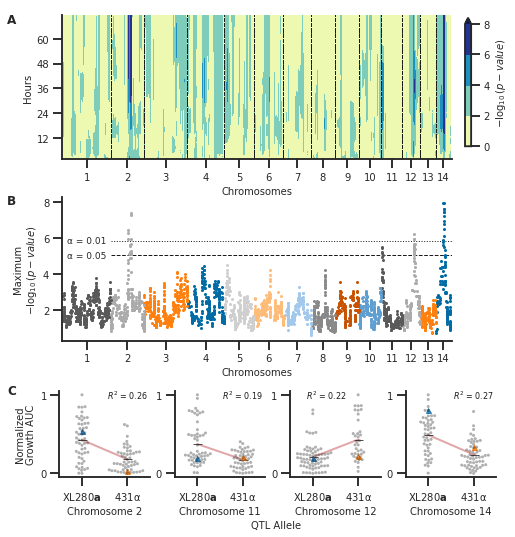

In [58]:
## Plot max asssocation across time and conditon per QTL
fig, ax = plt.subplots(2,1,figsize=(7,6),sharex=True)
plt.sca(ax[0])

## Plot max temproal plot
myfs = 10
for c,chrom in enumerate(chrlist):

    temp = qtlxtix[(qtlxtix.Chrom==chrom)][times_ixs+['Pos']]
    chpos = temp.Pos.values + cumpos[c]
    cs = ax[0].contourf(chpos,timex,temp[times_ixs].T.values,
                        cmap="YlGnBu",
                        levels = np.arange(0,9,2),extend='max');
    
    plt.vlines(np.array(clens[:-1]) + np.array(cumpos[:-1]),
                         1.75,np.max(timex),
           color='k',linewidth=1,linestyle='--');
    
    plt.xticks(chrom_midpts,labels=np.arange(1,15),
                    fontsize=myfs);
    
    plt.sca(ax[0])
    plt.yticks([12,24,36,48,60],fontsize=myfs)
    
## Label and add color bar
plt.xlabel('Chromosomes',fontsize=myfs);
plt.ylabel('Hours',fontsize=myfs)
plt.yticks(fontsize=myfs)

cbarax = fig.add_axes([.67,0.55,0.3,0.35])
cbar = plt.colorbar(cs, shrink=.85,
             #label='$-\log_{10}\,(p-value)$',
             orientation='vertical',ax=cbarax)

cbar.ax.tick_params(labelsize=myfs) 
cbar.set_label('$-\log_{10}\,(p-value)$',size=myfs)
plt.sca(cbarax)
plt.axis('off')

## Remove right and top spines of axis 
ax[0].xaxis.set_tick_params(which='both',labelbottom=True);
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)

## Max of max Mannhant plot
myms = 4

## Plot significant thresholds
plt.sca(ax[1])
[plt.hlines(a,cumpos[1],19*(10**6),
           linestyles=list(sigs_ls)[i],color='k',
            linewidth=1,label=sig_labs[i]) 
 for i,a in enumerate(thresholds[(thresholds.Stat=='Max')][
     ['0.05','0.01']].max().values[::-1])]

[plt.text(x=200000,y=a,s=sig_labs[i],va='center',ha='left',
          fontsize=myfs-1) 
 for i,a in enumerate(thresholds[(thresholds.Stat=='Max')][
     ['0.05','0.01']].max().values[::-1])]

## Plot QTL
for c in chrlist[::-1]:
    #i = int(c[-2:])-1
    #if c in ['Chr02','Chr11','Chr14']:
    #    plt.plot(qtlmaxt[(qtlmaxt.Chrom==c)].Cumpos.values,
    #      qtlmaxt[(qtlmaxt.Chrom==c)].Max.values,'.',
    #             ms=myms,color='tab:blue')
    #elif c in ['Chr12']:
    #    plt.plot(qtlmaxt[(qtlmaxt.Chrom==c)].Cumpos.values,
    #          qtlmaxt[(qtlmaxt.Chrom==c)].Max.values,'.',
    #             ms=myms,color='tab:orange');
    #else:
    plt.plot(qtlmaxt[(qtlmaxt.Chrom==c)].Cumpos.values,
          qtlmaxt[(qtlmaxt.Chrom==c)].Max.values,'.',
                 ms=myms)#,color=chrom_colors[i%len(chrom_colors)])

## Add QTL x and y labels and ticks 
plt.xticks(chrom_midpts,
           labels=np.arange(1,len(chrlist)+1),
           fontsize=myfs);
plt.xlabel('Chromosomes',fontsize=myfs);
plt.yticks([2,4,6,8],fontsize=myfs)
plt.ylabel(u'Maximum\n$-\log_{10}\,(p-value)$',
           fontsize=myfs);

## Remove axis set 
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
plt.xlim(-50000,xmax+50000)

## Addjust suplots of temporal and manhattan
plt.subplots_adjust(wspace=0.08,hspace=0.26);

## Initilizes lists
qtl_info_save = []
resids = []

## For each max QTL
for i, j in enumerate(qtlmax_info.iterrows()):
    ## make axis remove spines
    az = fig.add_axes([.12 + (.229*i),-0.19,0.18,0.2])
    plt.sca(az)
    az.spines['right'].set_visible(False)
    az.spines['top'].set_visible(False)
    
    temp_auc = qtlmax_AUC[j[1].Maxtime]
    temp_gv = qtlmax_gv[j[0]]
    temp_df = pd.concat([temp_auc,temp_gv],sort=True,axis=1).dropna()
    temp_df.columns = ['auc','gt']
    temp_df['auc'] = myminmax(temp_df.auc.values)
    
    ## Plot regression and swarmplot
    sns.regplot(x='gt',y='auc',data=temp_df,ci=False,
                scatter_kws={'alpha':0.0},
                line_kws={'linewidth':2,'alpha':0.5,'color':'r'})
    
    sns.swarmplot(x='gt',y='auc',size=3,
                  rasterized=True,
                  data=temp_df,color='k',
                  alpha=.35)
    
    plt.plot(temp_df.groupby('gt').mean().index,
             temp_df.groupby('gt').mean(),'k_',
             alpha=0.75,markersize=9)
    
    plt.plot(*temp_df.T['XL280a'].values[::-1],'^',
             color='tab:blue',
             alpha=.9,markersize=5)
    plt.plot(*temp_df.T['SS-A837'].values[::-1],'^',
             color='tab:orange',
             alpha=.9,markersize=5)
        
    plt.ylabel('Normalized\nGrowth AUC' if i == 0 else None,
               fontsize=myfs)
    plt.xticks([0,1],labels=[xl280a,_431],fontsize=myfs)

    plt.xlabel('Chromosome %s'%(
        int(j[1].Chrom[-2:])),fontsize=myfs)
    

    qtlfit = smf.ols('auc~gt',data=temp_df).fit()
    r2 = str(np.round(qtlfit.rsquared,2))
    resids.append(qtlfit.resid)

    az.text(abs(temp_df.T[temp_df['auc'].idxmax()].T['gt'] -1) 
            if i != 2 else 0.3,1,'$R^{2}$ = %s'%r2,
             color='k',alpha=1,va='center',
            ha='center',fontsize=myfs-2)
    plt.yticks([0,1],fontsize=myfs)
    
## Add a,b,c lables and x label on c   
fig.text(0.035,0.87,'A',ha='right',va='center',
         fontweight='bold',fontsize=myfs+2);
fig.text(0.035,0.45,'B',ha='right',va='center',
         fontweight='bold',fontsize=myfs+2);
fig.text(0.035,0.01,'C',ha='right',va='center',
         fontweight='bold',fontsize=myfs+2);
fig.text(0.55,-0.3,'QTL Allele',fontsize=myfs,
         va='center',ha='center')

plt.savefig('../FIGURES/MAIN/PDFs/Fig5.pdf',
            dpi=mydpi,bbox_inches='tight')

plos_save = '../FIGURES/MAIN/TIFF/Fig5.tiff'
plt.savefig(plos_save,dpi=mydpi,bbox_inches='tight');

im = Image.open(plos_save)
w,h = im.size
assert w/mydpi < 7.5
assert h/mydpi < 8

im.save(plos_save,compression='tiff_lzw');

## Load gene anlaysis
gene_analysis = pd.read_csv(gene_analysis_path)

## Load gff file
gff = pd.read_csv(gff_path,index_col=0)

## Take genes
gene_analysis2 = gene_analysis.merge(gff[(gff.type=='gene')
                                        ][['gene','start','end']])

## What are the outcomes in the gene analysis nonsense columsn
gene_analysis2.nonsense.unique()

In [59]:
## Take max chromosomes
## Shuould also match our significant list
max_chroms =  qtlmax_info.Chrom.tolist()
max_chroms

['Chr02', 'Chr11', 'Chr12', 'Chr14']

In [60]:
## Set colors
gene_colors = ['blue','orange','red']

In [61]:
## Rename thresholds
mt1 = thresholds[(thresholds.Stat=='Max')]['0.01'].max()
mt5 = thresholds[(thresholds.Stat=='Max')]['0.05'].max()

In [62]:
qtlbounds = []
co = mt5
for i,j in enumerate(max_chroms):
    
    #if i == 1 and j == 'Chr11':
    #    co = mt5
    #else:
    #    co = mt1
    ci = int(j[-2:])-1
    
    btemp = qtlmaxt[(qtlmaxt.Max>=co) & (qtlmaxt.Chrom==j)].copy()
    btemp['Pos'] = btemp['Cumpos'] - cumpos[ci]
    qtlbounds.append(btemp)

In [63]:
maxqtl_info = pd.concat(qtlbounds)
maxqtl_info.to_csv('../DATA/Max_QTL_bounds.csv');

In [64]:
#maxqtl_info = pd.read_csv('../DATA/Max_QTL_bounds.csv',index_col=0)

maxqtl_info['Genoix'] = [geno_df[(geno_df.Chrom==mr.Chrom) & 
                               (geno_df.Pos==mr.Pos)].index.max() 
                                 for i,mr in maxqtl_info.iterrows()]

qtl_bounds = []
for i,cb in maxqtl_info.groupby('Chrom'):
    
    l = geno_df[(geno_df.Block == geno_df.loc[cb.Genoix.min(),'Block'])].Pos.min()
    r = geno_df[(geno_df.Block == geno_df.loc[cb.Genoix.max(),'Block'])].Pos.max()
    
    qtlb = (i,l,r)
    qtl_bounds.append(qtlb)
    
qtl_bounds = pd.DataFrame(qtl_bounds,columns=['Chrom','Left','Right'])
qtl_bounds

Chrom    Left    Right
0  Chr02  847396  1001789
1  Chr11   37942    98737
2  Chr12  552849   616400
3  Chr14  353726   423207

In [65]:
gene_changes = pd.read_csv('../DATA/Supplementary_Table_2.csv')

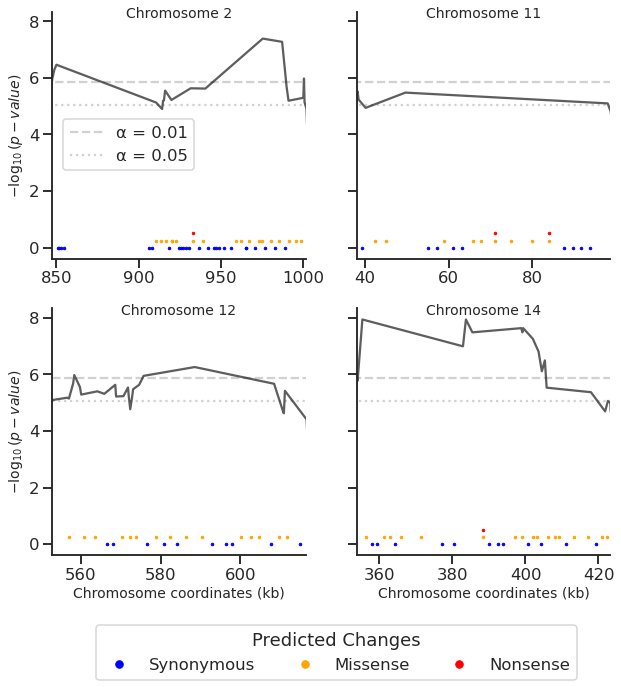

In [66]:
## Plot supplementary figure 9
fig, ax= plt.subplots(2,2,figsize=(10,10),sharey=True)
gene_label = ['Synonymous', 'Missense', 'Nonsense']

for i,c in enumerate(max_chroms):
    
    k = int(c[3:])-1
 
    cp = cumpos[k]
    plt.sca(ax.ravel()[i])

    plt.title('Chromosome %s'%str(k+1),fontsize=14,y=.95)
    
    [ax.ravel()[i].spines[l].set_visible(False) for l in ['top','right']]
    
    pv = qtlmaxt[(qtlmaxt.Chrom==c)]
    plt.plot((pv.Cumpos.values-cp)/1000,pv.Max.values,'k-',alpha=0.7);
    
    gt = gene_changes[(gene_changes.Chromosome==k+1)]
    invar = gt[(gt.No_nonsynonymous == 0)]
    isvar = gt[(gt.No_nonsynonymous > 0)]
    sg = gt[(gt['431_No_stop_codons']!= 1)]
    
    [plt.hlines(mt,0,(7/9)*(pv.Cumpos.max()-cp)/1000,
                linestyle='--' if z == 0 else ':',alpha=0.2,
                color='k',label = sig_labs[z] if i == 0 else None
               ) for z,mt in enumerate([mt1,mt5])]
    if i == 0:
        plt.legend(bbox_to_anchor=(0.01,0.6))
    
    plt.ylabel('$-\log_{10}\,(p-value)$' if i in [0,2] else None,fontsize=14);
    plt.xlabel('Chromosome coordinates (kb)' if i in [2,3] else None,fontsize=14)
    
    for m,j in enumerate([invar,isvar,sg]):
        
        plt.plot(j[['Start','End']].mean(axis=1).values/1000,
                 (0.25*m)*np.ones(len(j)),'.',
                 ms=5,color=gene_colors[m],
                 label=gene_label[m] if i == 3 else None)
        if i == 3:
            plt.legend(ncol=3,markerscale=3,
                       bbox_to_anchor=(0.9,-0.25),
                       title='Predicted Changes')
        

    plt.xlim(*qtl_bounds[(qtl_bounds.Chrom==c)][['Left','Right']].values/1000)
    
        
plt.savefig('../FIGURES/SUPP/PDFs/S9_Fig.pdf',
            dpi=300,bbox_inches='tight');

In [67]:
#gene_changes[(gene_changes.Contig=='Chr12')].sort_values('Start')

In [68]:
gene_changes[(gene_changes.Gene=='CNL05550')]

Empty DataFrame
Columns: [Gene, Chromosome, Start, End, Strand, Variants_in_gene, Upstream_variants, JEC21_protein_length, XL280_protein_length, 431_protein_length, XL280_No_stop_codons, 431_No_stop_codons, No_nonsynonymous, Utr_5_variants, Utr_3_variants, Exonic_variants, Intronic_variants, Description, Transcript]
Index: []

## Plot supplementary figure 9
fig, ax= plt.subplots(2,2,figsize=(10,10),sharey=True)
gene_label = ['Invariant', 'Missense', 'Stop-gain','Stop-loss']

for i,c in enumerate(max_chroms):
    
    k = int(c[3:])-1
 
    cp = cumpos[k]
    plt.sca(ax.ravel()[i])

    plt.title('Chromosome %s'%str(k+1),fontsize=14,y=.95)
    
    [ax.ravel()[i].spines[l].set_visible(False) for l in ['top','right']]
    
    gt = gene_analysis2[(gene_analysis2.chrom==c) & (gene_analysis2.mod_three==0)]
    pv = qtlmaxt[(qtlmaxt.Chrom==c)]
    plt.plot((pv.Cumpos.values-cp)/1000,pv.Max.values,'k-',alpha=0.7);
    
    invar = gt[(gt.nonsense==0) & (gt.missense==0)]
    isvar = gt[(gt.nonsense==0) & (gt.missense!=0)]
    sg = gt[(gt.nonsense==1)]
    sl = gt[(gt.nonsense==2)]
    [plt.hlines(mt,0,(7/9)*(pv.Cumpos.max()-cp)/1000,linestyle='--',color='k') 
     for mt in [mt1,mt5]]
    plt.ylabel('$-\log_{10}\,(p-value)$' if i in [0,2] else None,fontsize=14);
    plt.xlabel('Chromosome coordinates (kb)' if i in [2,3] else None,fontsize=14)
    [plt.text((12/13)*(pv.Cumpos.max()-cp)/1000,mt,sig_labs[i],
             fontsize=14,va='center',ha='center') for i,mt in enumerate([mt1,mt5])]
    
    
    for m,j in enumerate([invar,isvar,sg,sl]):
        
        plt.plot(j[['start','end']].mean(axis=1).values/1000,
                 (0.25*m)*np.ones(len(j)),'.',
                 ms=5,color=gene_colors[m],label=gene_label[m] if i == 1 else None)
        if i == 1:
            plt.legend(ncol=4,markerscale=4,
                       bbox_to_anchor=(1.051,1.3),
                       title='Gene changes')
        
        plt.text((12/10)*(pv.Cumpos.max()-cp)/1000,(0.65*m)-.8,
                 str(j.shape[0]),color=gene_colors[m],va='center',ha='right')
        
plt.savefig('../FIGURES/SUPP/PDFs/S9_Fig.pdf',
            dpi=300,bbox_inches='tight');